In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import rbf_kernel
from maad import sound
from sklearn.metrics.pairwise import polynomial_kernel, cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [3]:
start = 0
duration = 300

audio_data, sampling_rate = librosa.load('../../Data/ElephantIsland2014/wav/20140104_090000_AWI251-01_AU0231_250Hz.wav', sr=250, offset=start)
# audio_data, sampling_rate = librosa.load('../../DataSubmission/2023_04_22/20230422_171301.wav', offset=start, duration=duration, sr=8000)
# audio_data_resampled = librosa.resample(audio_data, orig_sr=8000, target_sr=2000)



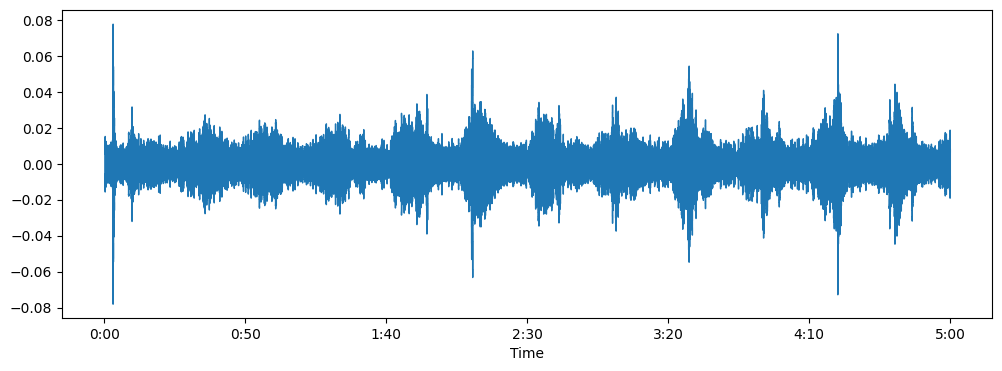

In [4]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_data, sr=sampling_rate)
plt.show()


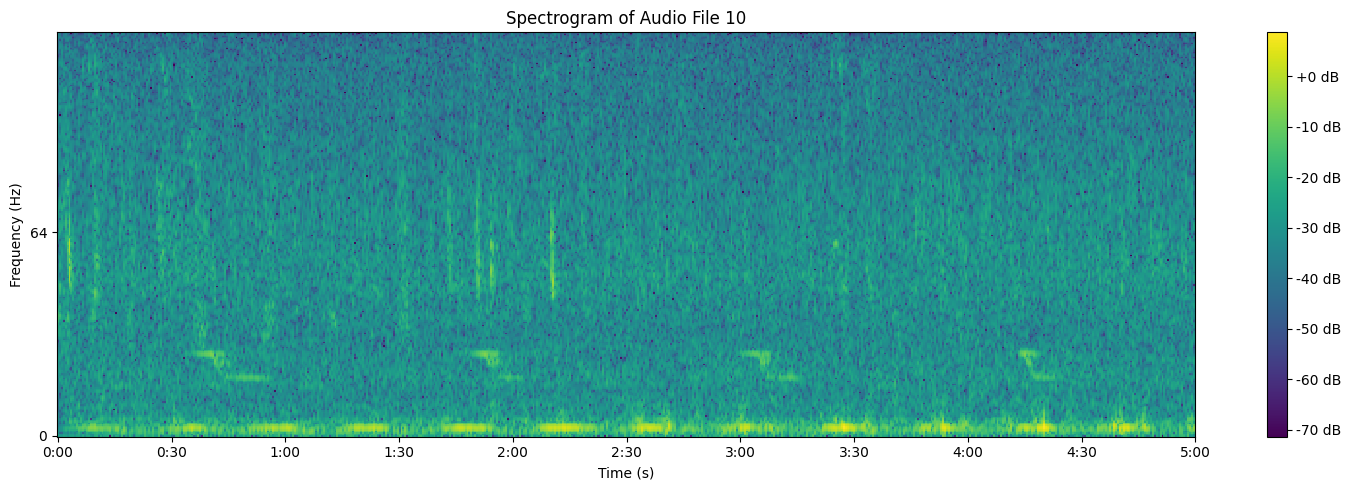

In [5]:

from matplotlib.ticker import FuncFormatter
def time_ticks(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    return f'{minutes}:{seconds:02d}'


window_length = 256
hop_length = 128
fft_size = 512

D = librosa.stft(audio_data, n_fft=fft_size, hop_length=hop_length, win_length=window_length, window='hann')
spectrogram = librosa.amplitude_to_db(np.abs(D))
power_spectrum=np.abs(D)**2

# Plot the spectrogram
plt.figure(figsize=(15, 5))
librosa.display.specshow(spectrogram, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Audio File 10')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(time_ticks))
plt.xticks(np.arange(0, 300 + 30, 30))
plt.tight_layout()
plt.show()



In [6]:
def extract_features(audio_data, sampling_rate, num_mfcc=20):

    # Bandpass filter applied
    filtered_audio = sound.select_bandwidth(audio_data, sampling_rate, fcut=(10,80), forder=7, ftype='bandpass')
    

    # Spectrogram with a hop length of 512
    Sxx_filtered, tn_filtered, fn_filtered, ext_filtered = sound.spectrogram(filtered_audio, sampling_rate, nperseg = 512)
      
    # Noise reduction -- optional for noisy recordings
    clean_audio, noise_profile, BGNxx = sound.remove_background(Sxx_filtered,sampling_rate, N=1024)
    
    #  Extracting MFCCs, Deltas, Chroma and Spectral Contrasts
    mfccs = librosa.feature.mfcc(S=Sxx_filtered, n_fft=fft_size, n_mfcc=num_mfcc)
    mfccs_delta = librosa.feature.delta(mfccs)
    chroma = librosa.feature.chroma_stft(S=Sxx_filtered, sr=sampling_rate, hop_length=512)
    spectral_contrast = librosa.feature.spectral_contrast(S=Sxx_filtered,sr=sampling_rate, fmin=20, n_bands=3)

    # Standardizing the features
    scaler = StandardScaler()
    mfccs_scaled = scaler.fit_transform(mfccs.T).T
    delta_scaled = scaler.fit_transform(mfccs_delta.T).T
    chroma_scaled = scaler.fit_transform(chroma.T).T
    spectral_scaled = scaler.fit_transform(spectral_contrast.T).T

    # Plot the spectrogram using matplotlib
    plt.figure(figsize=(15, 5))
    plt.imshow(Sxx_filtered, aspect='auto', extent=ext_filtered, origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Filtered Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

    return mfccs, mfccs_scaled, delta_scaled,chroma, chroma_scaled, spectral_scaled




In [7]:
from matplotlib.ticker import FuncFormatter
def time_ticks(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    return f'{minutes}:{seconds:02d}'

# Spectral clustering algorithm
def clustering(X, affinity_matrix, n_clusters, clustering_method="kmeans"):
   
    # Degree matrix
    degree_matrix = np.diag(np.sum(affinity_matrix, axis=1))
    epsilon = 1e-5  
    degree_matrix += np.eye(degree_matrix.shape[0]) * epsilon

    min_threshold = 1e-5  # Setting a minimum threshold to avoid small values causing issues
    degree_matrix = np.clip(degree_matrix, min_threshold, None)

    sqrt_deg_matrix = np.diag(1.0 / np.sqrt(np.diag(degree_matrix)))
    norm_laplacian_matrix = np.eye(degree_matrix.shape[0]) - sqrt_deg_matrix @ affinity_matrix @ sqrt_deg_matrix

    # Eigenvalue decomposition
    eig_values, eig_vectors = eigh(norm_laplacian_matrix)
    idx = eig_values.argsort()
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]

    # Extracting the 3 largest eigenvectors
    k = 3
    feature_vector = eig_vectors[:, :k]
    
    # Clustering the eigenvectors
    if clustering_method == 'kmeans':
        cluster = KMeans(n_clusters=n_clusters, n_init=50)
    elif clustering_method == 'gmm':
        cluster = GaussianMixture(n_components=n_clusters)

    labels = cluster.fit_predict(feature_vector)

    # Check the number of unique labels
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        print("Warning: Only one cluster found. Silhouette score cannot be calculated.")
        return labels, None
    
    # Extracting the silhouette score
    silhouette = silhouette_score(X, labels)
    
    
    return labels, silhouette

    
    




C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


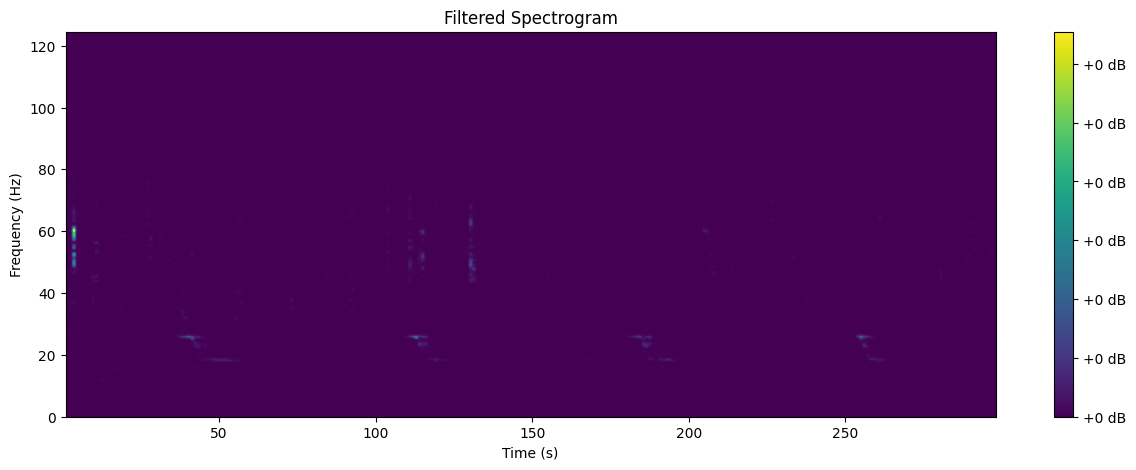

Feature Set: mfccs, Affinity: rbf, Method: kmeans, Silhouette: 0.7661807237290751


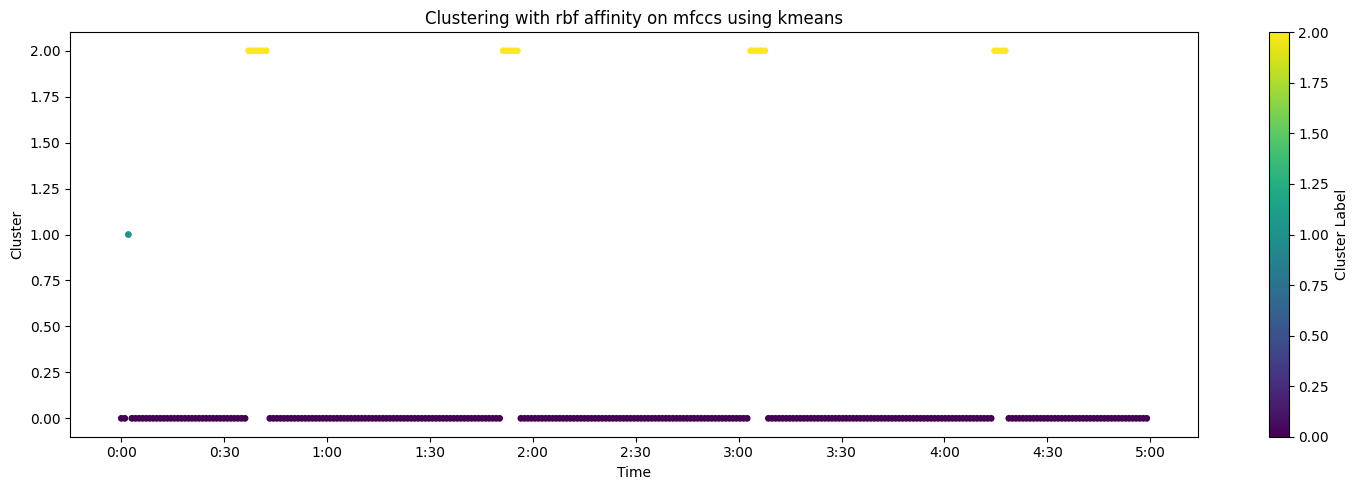

Timestamps for points in cluster 2:
37.11 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
20
Feature Set: mfccs, Affinity: rbf, Method: gmm, Silhouette: 0.6921534395537962


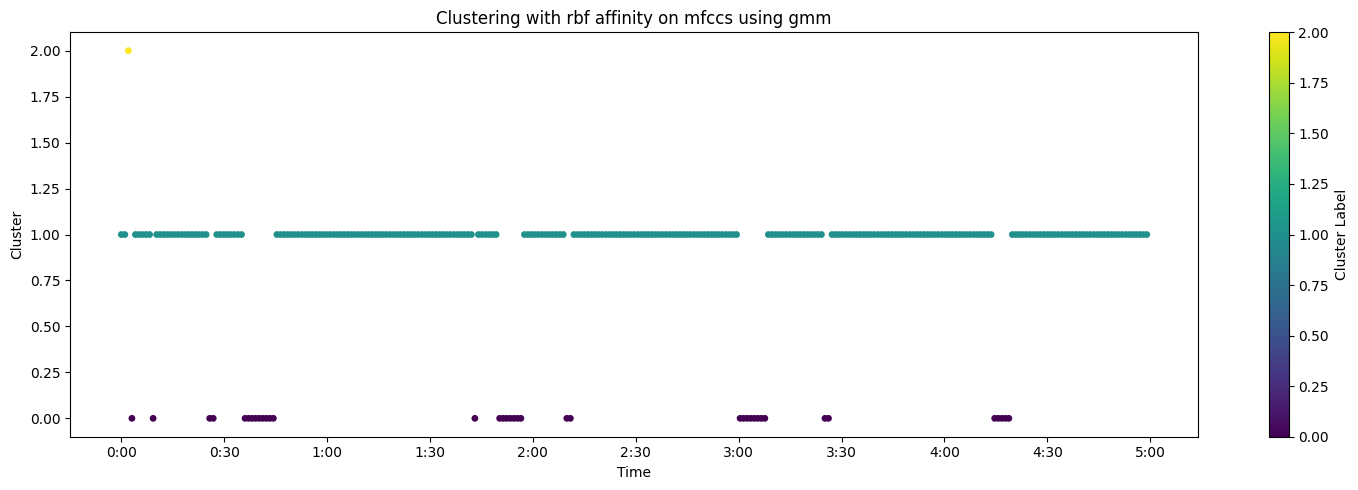

Timestamps for points in cluster 2:
2.06 seconds
1
Feature Set: mfccs, Affinity: cosine, Method: kmeans, Silhouette: -0.09330394325339754


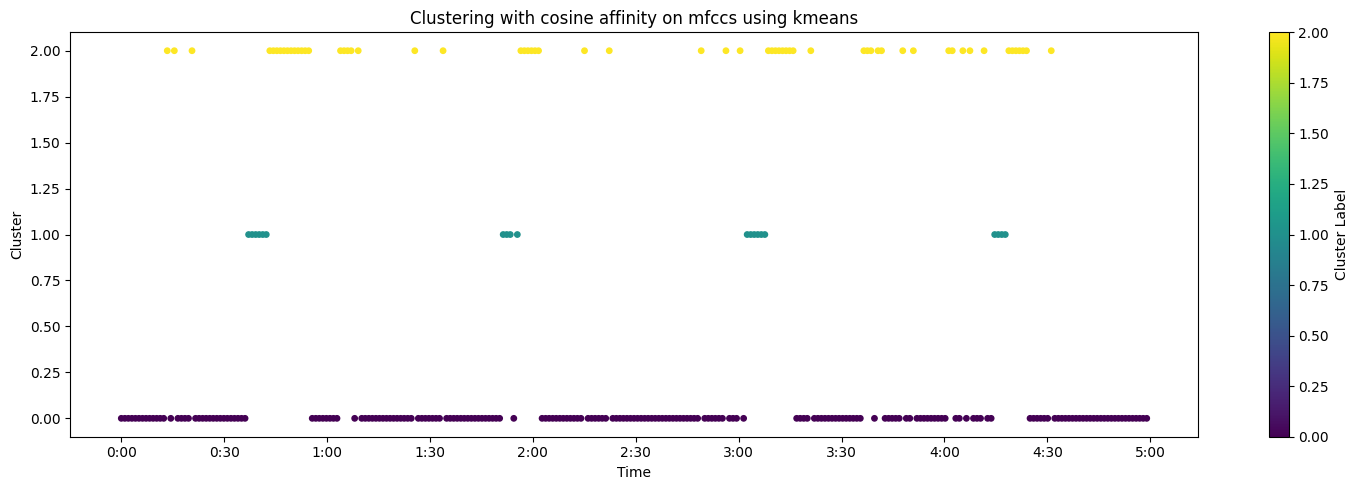

Timestamps for points in cluster 2:
13.40 seconds
15.46 seconds
20.62 seconds
43.30 seconds
44.33 seconds
45.36 seconds
46.39 seconds
47.42 seconds
48.45 seconds
49.48 seconds
50.52 seconds
51.55 seconds
52.58 seconds
53.61 seconds
54.64 seconds
63.92 seconds
64.95 seconds
65.98 seconds
67.01 seconds
69.07 seconds
85.57 seconds
93.81 seconds
116.49 seconds
117.53 seconds
118.56 seconds
119.59 seconds
120.62 seconds
121.65 seconds
135.05 seconds
142.27 seconds
169.07 seconds
176.29 seconds
180.41 seconds
188.66 seconds
189.69 seconds
190.72 seconds
191.75 seconds
192.78 seconds
193.81 seconds
194.85 seconds
195.88 seconds
201.03 seconds
216.49 seconds
217.53 seconds
218.56 seconds
220.62 seconds
221.65 seconds
227.84 seconds
230.93 seconds
241.24 seconds
242.27 seconds
245.36 seconds
247.42 seconds
251.55 seconds
258.76 seconds
259.79 seconds
260.82 seconds
261.86 seconds
262.89 seconds
263.92 seconds
271.13 seconds
61
Feature Set: mfccs, Affinity: cosine, Method: gmm, Silhouette: -0.12

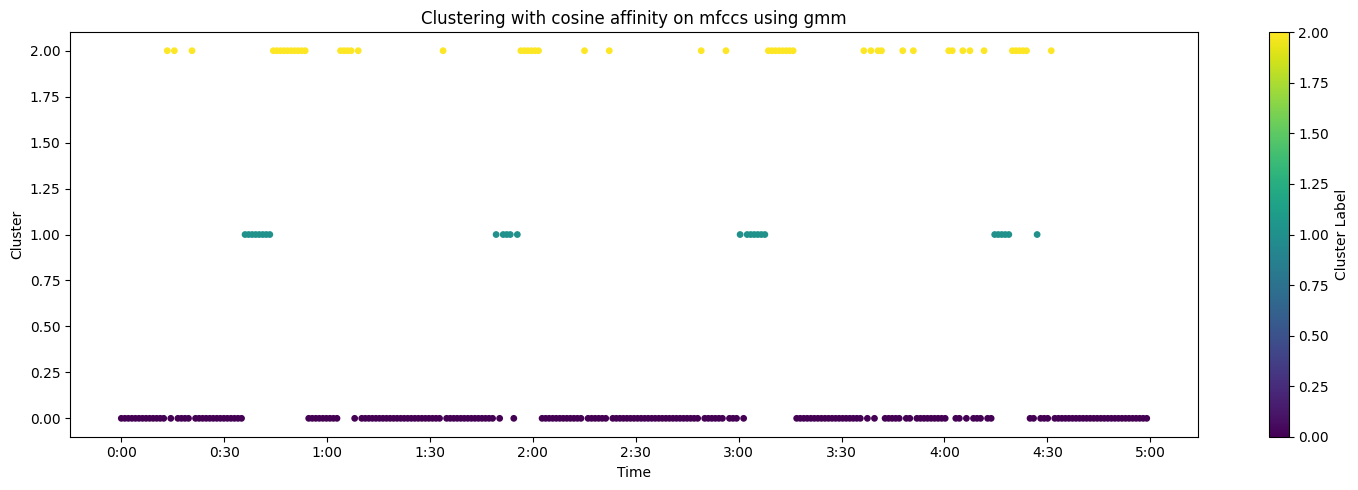

Timestamps for points in cluster 2:
13.40 seconds
15.46 seconds
20.62 seconds
44.33 seconds
45.36 seconds
46.39 seconds
47.42 seconds
48.45 seconds
49.48 seconds
50.52 seconds
51.55 seconds
52.58 seconds
53.61 seconds
63.92 seconds
64.95 seconds
65.98 seconds
67.01 seconds
69.07 seconds
93.81 seconds
116.49 seconds
117.53 seconds
118.56 seconds
119.59 seconds
120.62 seconds
121.65 seconds
135.05 seconds
142.27 seconds
169.07 seconds
176.29 seconds
188.66 seconds
189.69 seconds
190.72 seconds
191.75 seconds
192.78 seconds
193.81 seconds
194.85 seconds
195.88 seconds
216.49 seconds
218.56 seconds
220.62 seconds
221.65 seconds
227.84 seconds
230.93 seconds
241.24 seconds
242.27 seconds
245.36 seconds
247.42 seconds
251.55 seconds
259.79 seconds
260.82 seconds
261.86 seconds
262.89 seconds
263.92 seconds
271.13 seconds
54
Feature Set: mfccs, Affinity: polynomial, Method: kmeans, Silhouette: 0.770246320780105


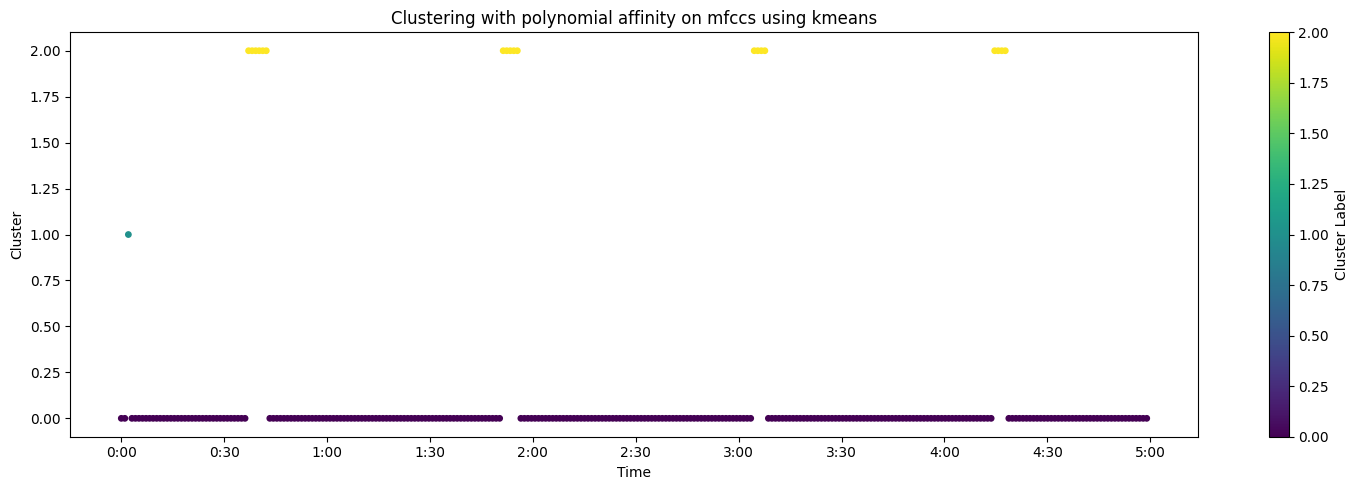

Timestamps for points in cluster 2:
37.11 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
19
Feature Set: mfccs, Affinity: polynomial, Method: gmm, Silhouette: 0.6921534395537962


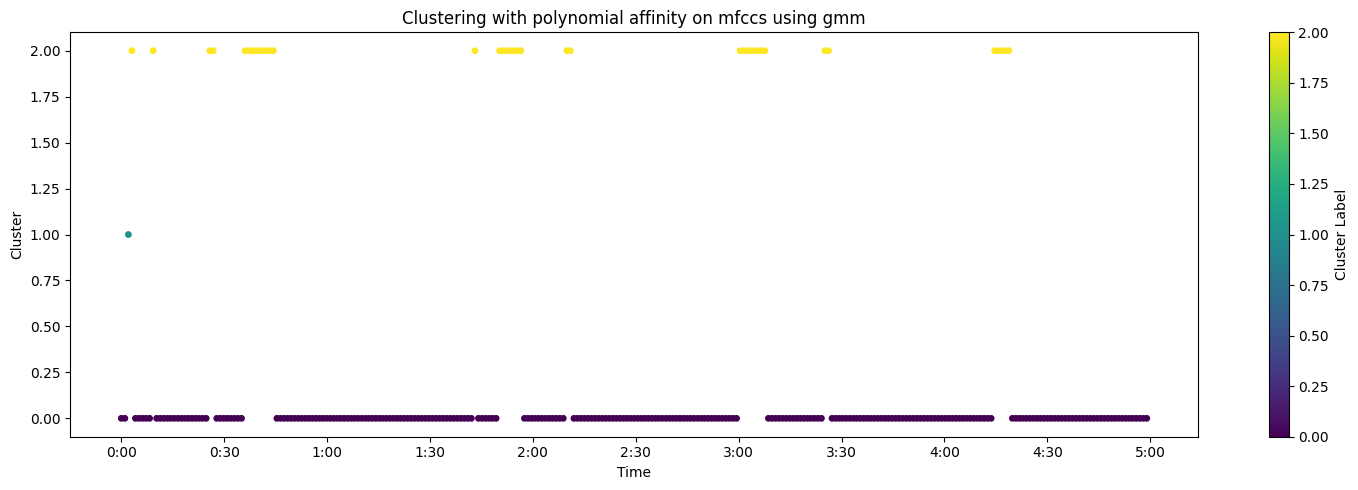

Timestamps for points in cluster 2:
3.09 seconds
9.28 seconds
25.77 seconds
26.80 seconds
36.08 seconds
37.11 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
43.30 seconds
44.33 seconds
103.09 seconds
110.31 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
116.49 seconds
129.90 seconds
130.93 seconds
180.41 seconds
181.44 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
205.15 seconds
206.19 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
258.76 seconds
38
Feature Set: mfccs, Affinity: dot_product, Method: kmeans, Silhouette: 0.7661807237290751


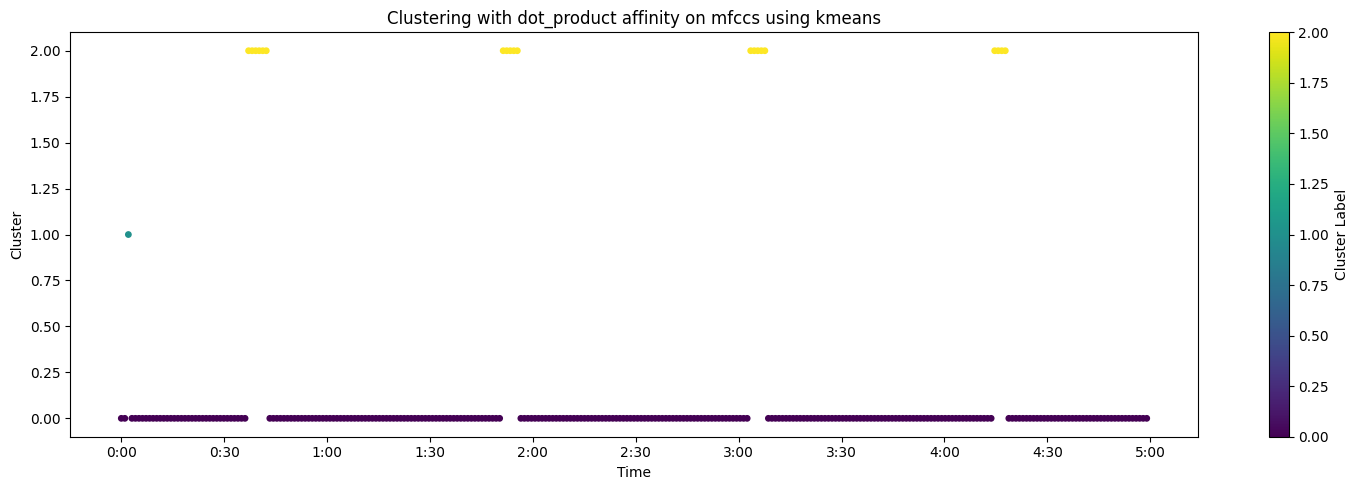

Timestamps for points in cluster 2:
37.11 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
20
Feature Set: mfccs, Affinity: dot_product, Method: gmm, Silhouette: 0.7040662002543602


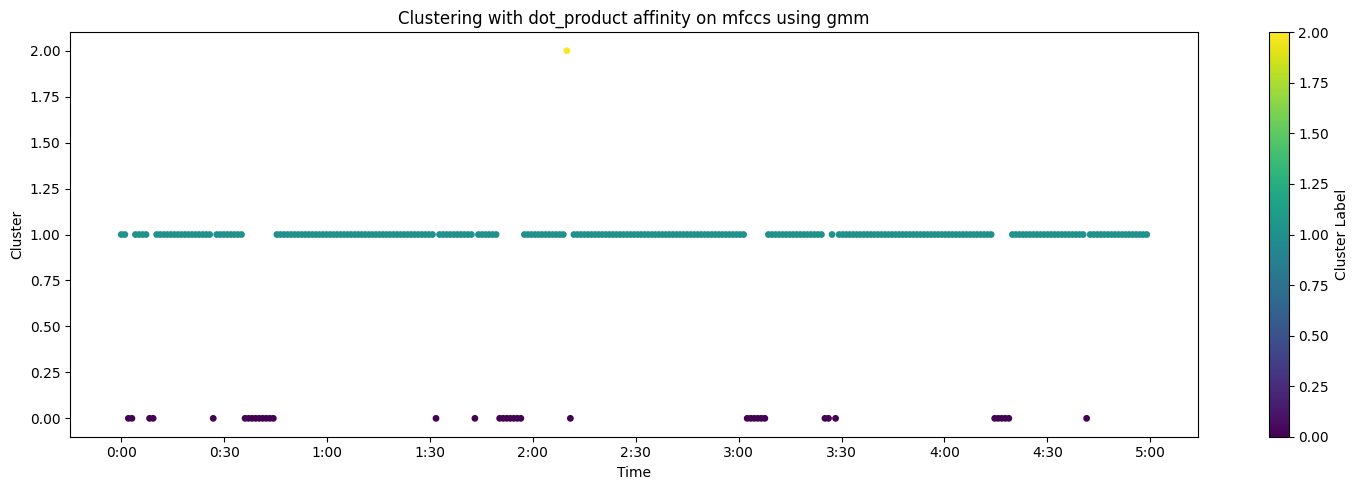

Timestamps for points in cluster 2:
129.90 seconds
1
Feature Set: mfccs_scaled, Affinity: rbf, Method: kmeans, Silhouette: 0.8994277934642292


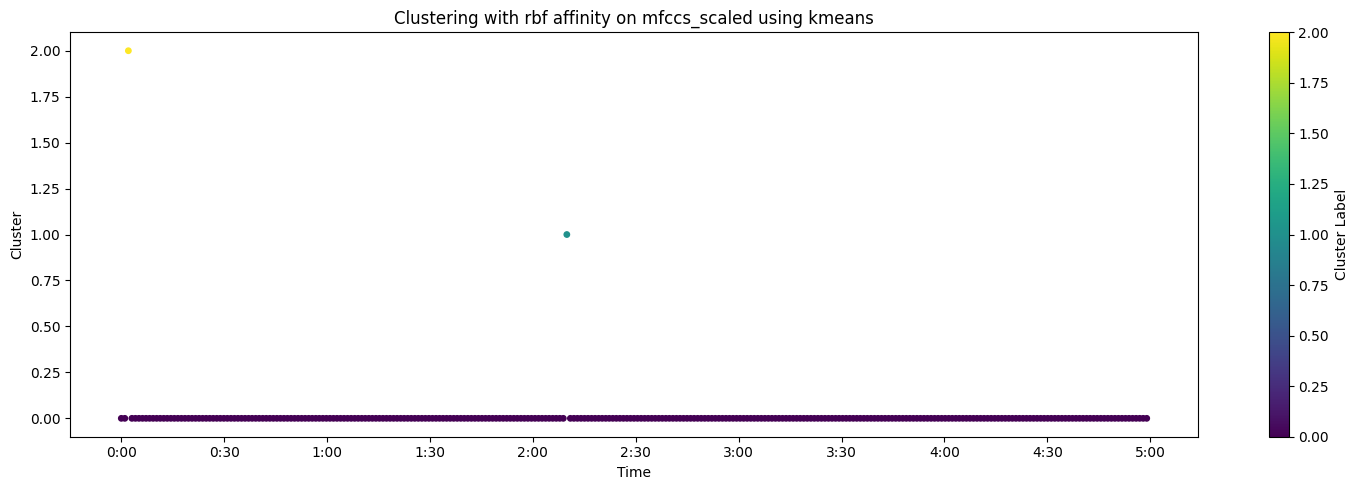

Timestamps for points in cluster 2:
2.06 seconds
1
Feature Set: mfccs_scaled, Affinity: rbf, Method: gmm, Silhouette: 0.8994277934642292


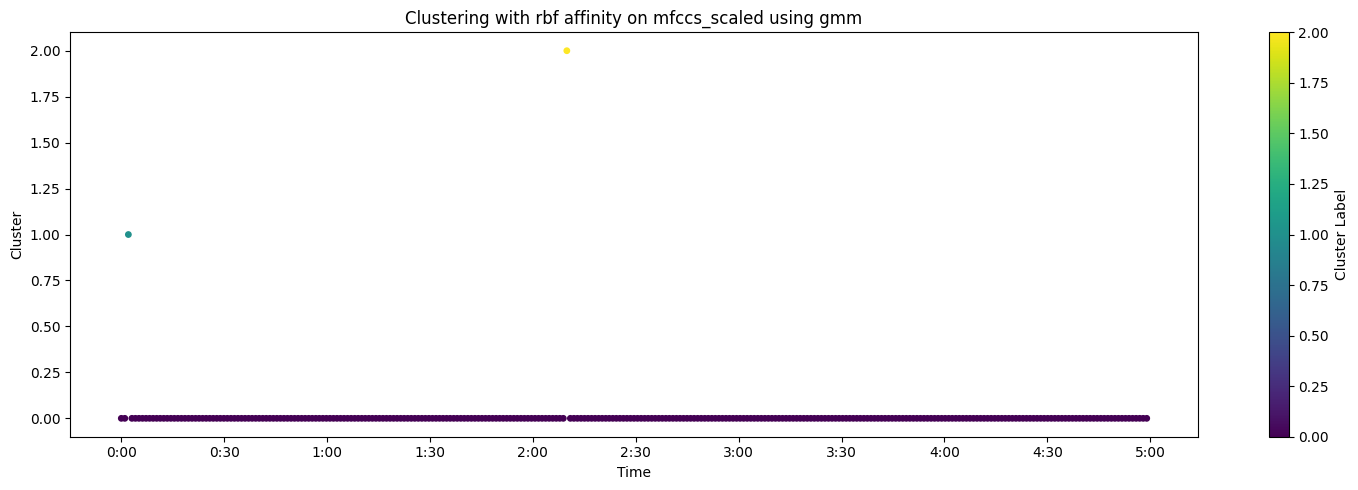

Timestamps for points in cluster 2:
129.90 seconds
1
Feature Set: mfccs_scaled, Affinity: cosine, Method: kmeans, Silhouette: 0.6389265422561783


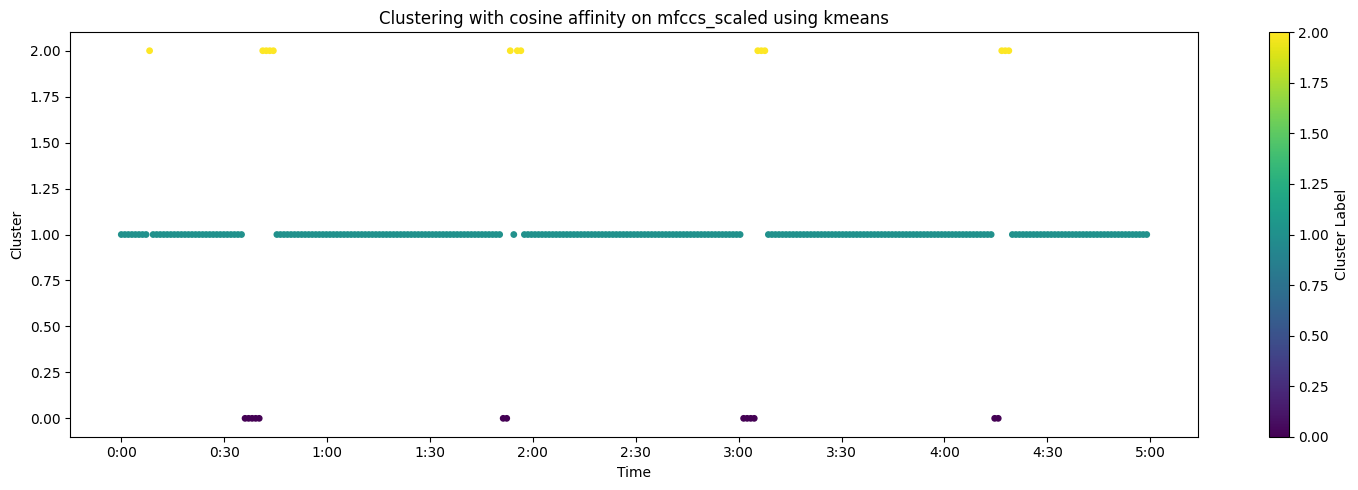

Timestamps for points in cluster 2:
8.25 seconds
41.24 seconds
42.27 seconds
43.30 seconds
44.33 seconds
113.40 seconds
115.46 seconds
116.49 seconds
185.57 seconds
186.60 seconds
187.63 seconds
256.70 seconds
257.73 seconds
258.76 seconds
14
Feature Set: mfccs_scaled, Affinity: cosine, Method: gmm, Silhouette: 0.7082717920075609


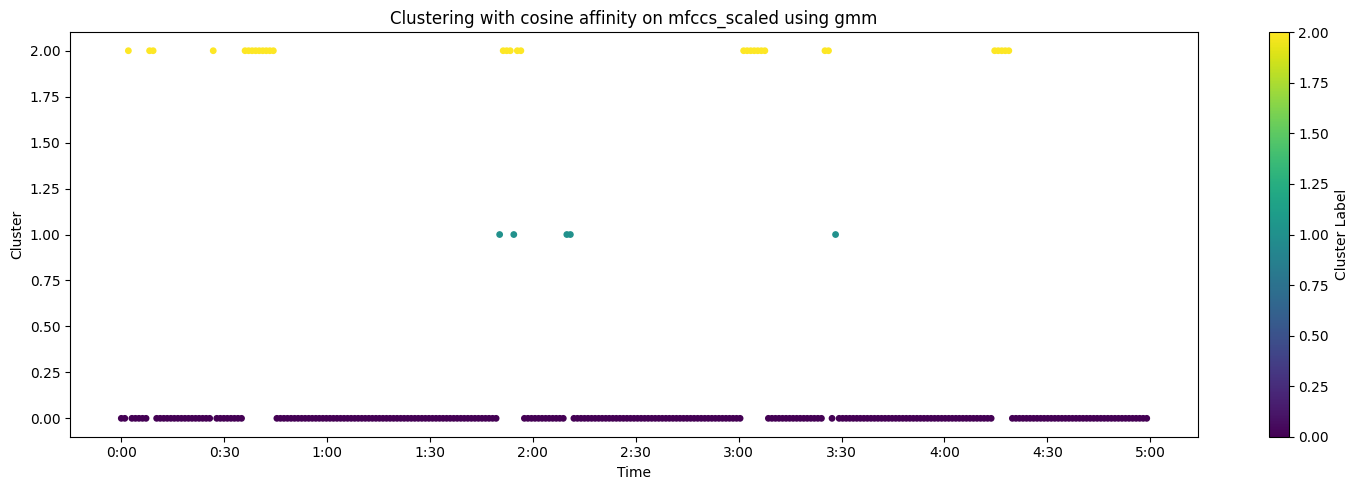

Timestamps for points in cluster 2:
2.06 seconds
8.25 seconds
9.28 seconds
26.80 seconds
36.08 seconds
37.11 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
43.30 seconds
44.33 seconds
111.34 seconds
112.37 seconds
113.40 seconds
115.46 seconds
116.49 seconds
181.44 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
205.15 seconds
206.19 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
258.76 seconds
32
Feature Set: mfccs_scaled, Affinity: polynomial, Method: kmeans, Silhouette: 0.8994277934642292


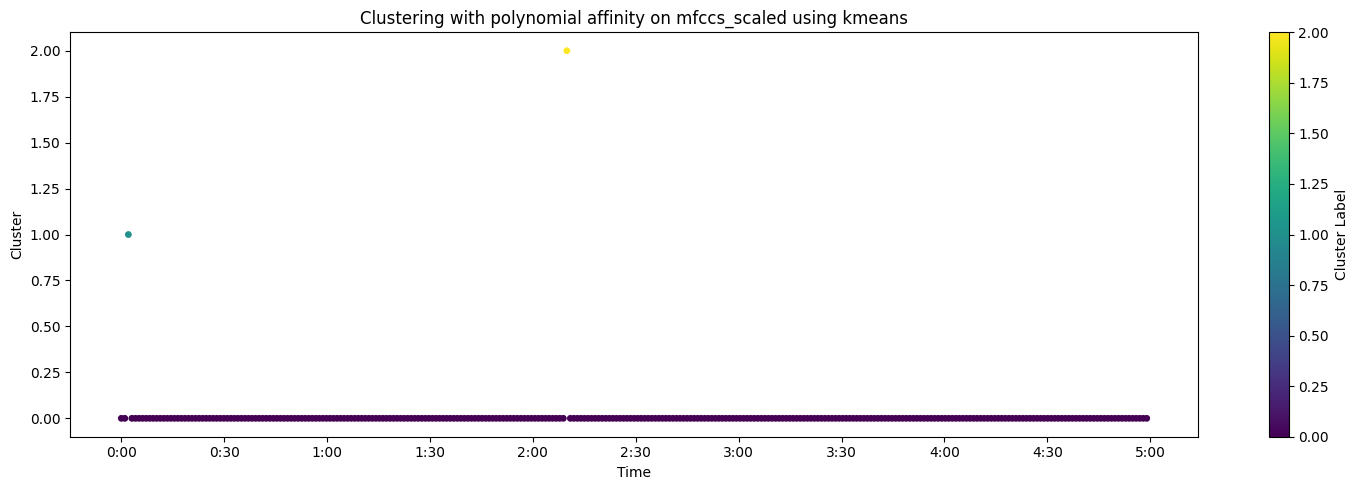

Timestamps for points in cluster 2:
129.90 seconds
1
Feature Set: mfccs_scaled, Affinity: polynomial, Method: gmm, Silhouette: 0.8994277934642292


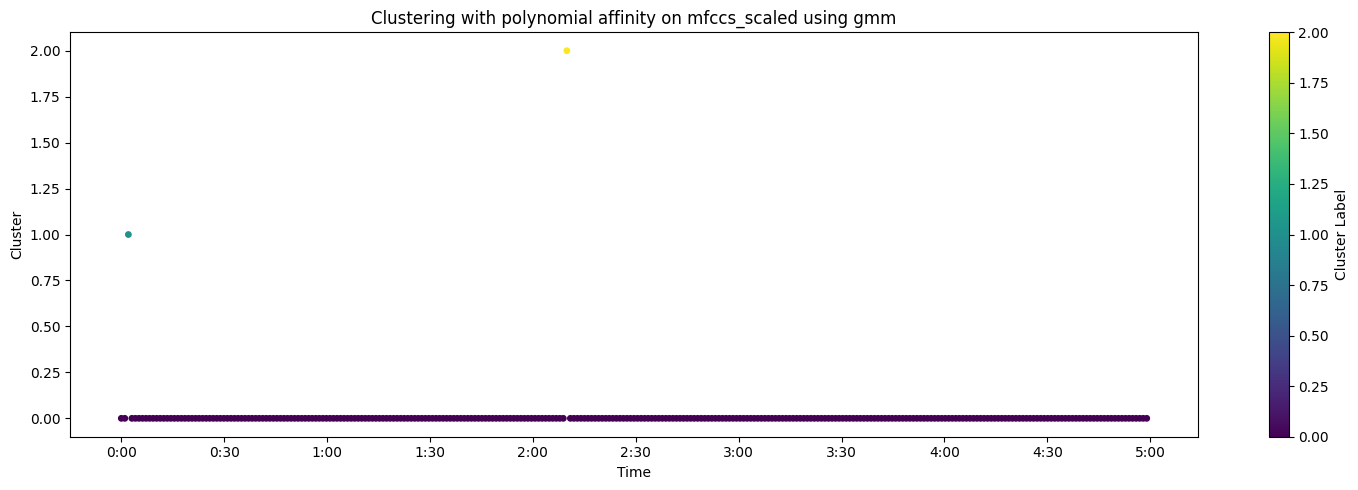

Timestamps for points in cluster 2:
129.90 seconds
1
Feature Set: mfccs_scaled, Affinity: dot_product, Method: kmeans, Silhouette: 0.7731889453991065


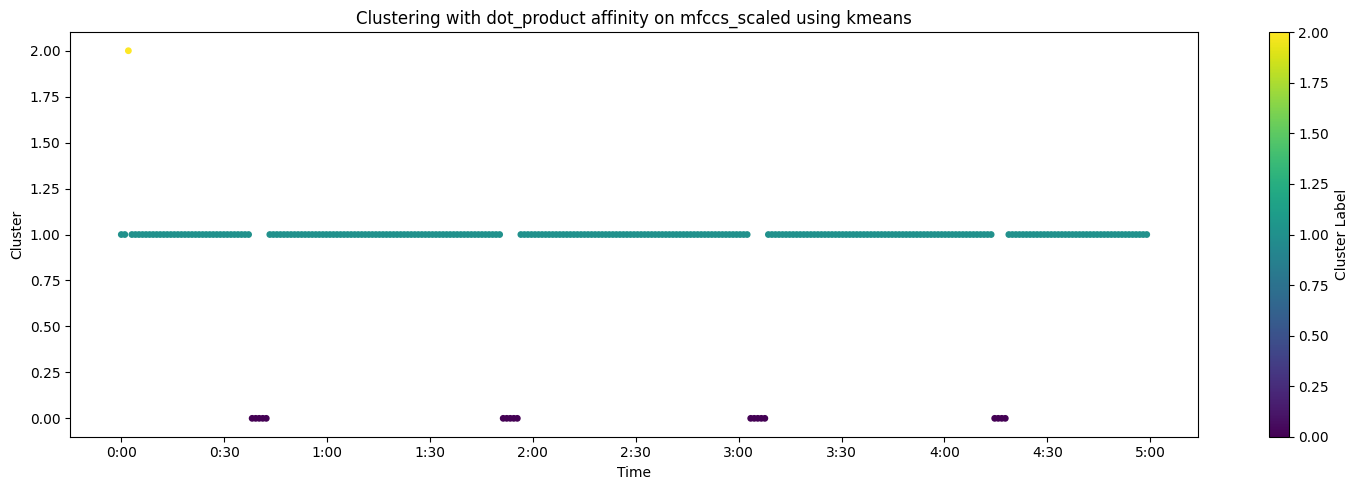

Timestamps for points in cluster 2:
2.06 seconds
1
Feature Set: mfccs_scaled, Affinity: dot_product, Method: gmm, Silhouette: 0.6790843616914025


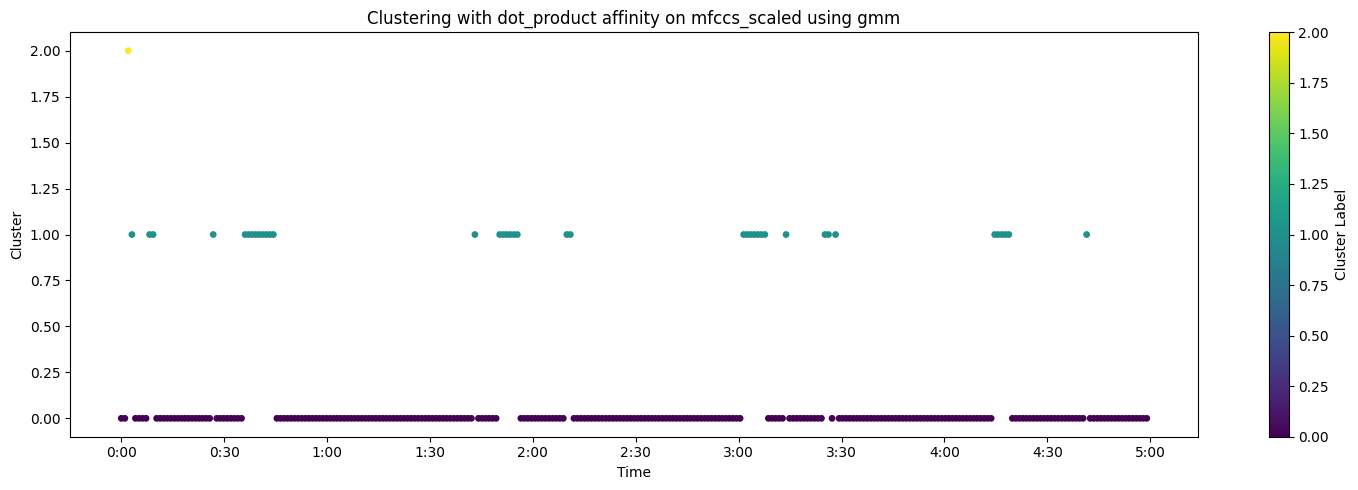

Timestamps for points in cluster 2:
2.06 seconds
1
Feature Set: chroma, Affinity: rbf, Method: kmeans, Silhouette: 0.18678029836110188


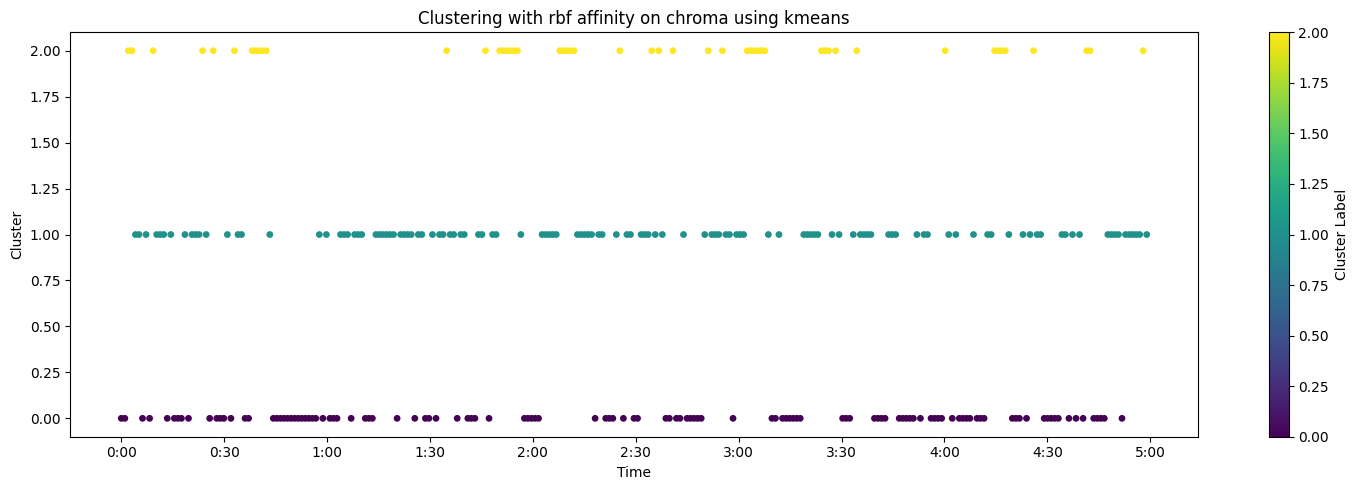

Timestamps for points in cluster 2:
2.06 seconds
3.09 seconds
9.28 seconds
23.71 seconds
26.80 seconds
32.99 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
94.85 seconds
106.19 seconds
110.31 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
127.84 seconds
128.87 seconds
129.90 seconds
130.93 seconds
131.96 seconds
145.36 seconds
154.64 seconds
156.70 seconds
160.82 seconds
171.13 seconds
175.26 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
204.12 seconds
205.15 seconds
206.19 seconds
208.25 seconds
214.43 seconds
240.21 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
265.98 seconds
281.44 seconds
282.47 seconds
297.94 seconds
50
Feature Set: chroma, Affinity: rbf, Method: gmm, Silhouette: 0.1872787640981923


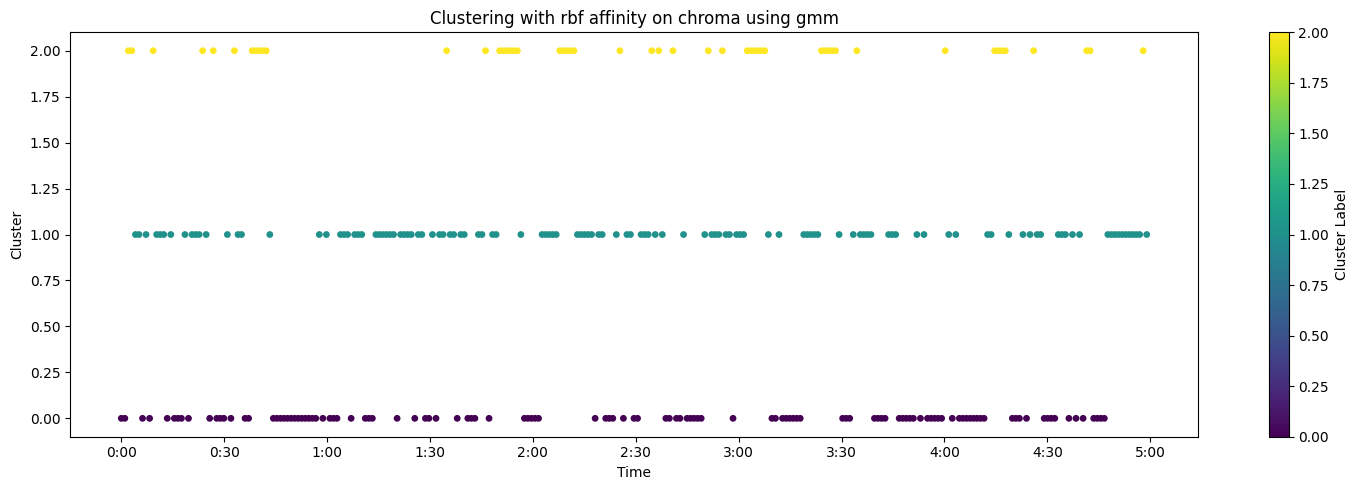

Timestamps for points in cluster 2:
2.06 seconds
3.09 seconds
9.28 seconds
23.71 seconds
26.80 seconds
32.99 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
94.85 seconds
106.19 seconds
110.31 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
127.84 seconds
128.87 seconds
129.90 seconds
130.93 seconds
131.96 seconds
145.36 seconds
154.64 seconds
156.70 seconds
160.82 seconds
171.13 seconds
175.26 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
204.12 seconds
205.15 seconds
206.19 seconds
207.22 seconds
208.25 seconds
214.43 seconds
240.21 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
265.98 seconds
281.44 seconds
282.47 seconds
297.94 seconds
51
Feature Set: chroma, Affinity: cosine, Method: kmeans, Silhouette: 0.14857053686637287


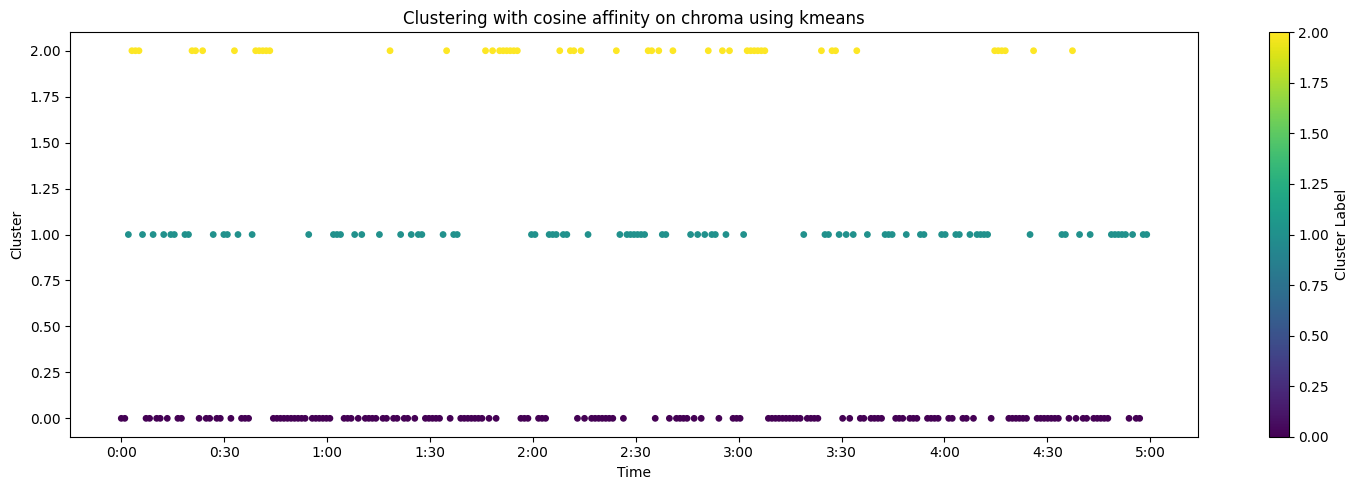

Timestamps for points in cluster 2:
3.09 seconds
4.12 seconds
5.15 seconds
20.62 seconds
21.65 seconds
23.71 seconds
32.99 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
43.30 seconds
78.35 seconds
94.85 seconds
106.19 seconds
108.25 seconds
110.31 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
127.84 seconds
130.93 seconds
131.96 seconds
134.02 seconds
144.33 seconds
153.61 seconds
154.64 seconds
156.70 seconds
160.82 seconds
171.13 seconds
175.26 seconds
177.32 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
204.12 seconds
207.22 seconds
208.25 seconds
214.43 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
265.98 seconds
277.32 seconds
50
Feature Set: chroma, Affinity: cosine, Method: gmm, Silhouette: 0.19999062194911957


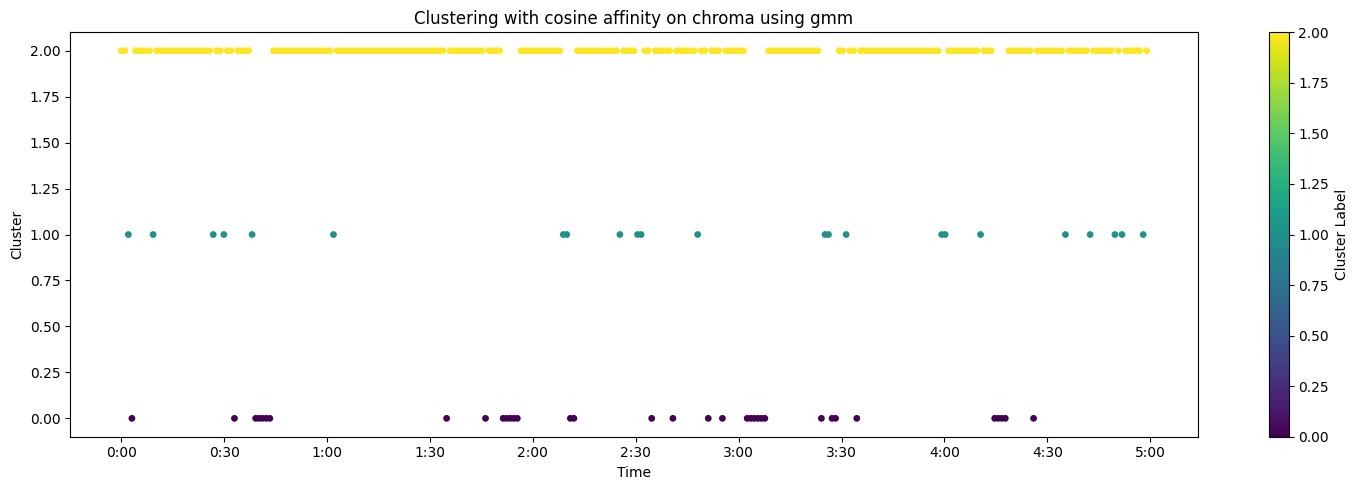

Timestamps for points in cluster 2:
0.00 seconds
1.03 seconds
4.12 seconds
5.15 seconds
6.19 seconds
7.22 seconds
8.25 seconds
10.31 seconds
11.34 seconds
12.37 seconds
13.40 seconds
14.43 seconds
15.46 seconds
16.49 seconds
17.53 seconds
18.56 seconds
19.59 seconds
20.62 seconds
21.65 seconds
22.68 seconds
23.71 seconds
24.74 seconds
25.77 seconds
27.84 seconds
28.87 seconds
30.93 seconds
31.96 seconds
34.02 seconds
35.05 seconds
36.08 seconds
37.11 seconds
44.33 seconds
45.36 seconds
46.39 seconds
47.42 seconds
48.45 seconds
49.48 seconds
50.52 seconds
51.55 seconds
52.58 seconds
53.61 seconds
54.64 seconds
55.67 seconds
56.70 seconds
57.73 seconds
58.76 seconds
59.79 seconds
60.82 seconds
62.89 seconds
63.92 seconds
64.95 seconds
65.98 seconds
67.01 seconds
68.04 seconds
69.07 seconds
70.10 seconds
71.13 seconds
72.16 seconds
73.20 seconds
74.23 seconds
75.26 seconds
76.29 seconds
77.32 seconds
78.35 seconds
79.38 seconds
80.41 seconds
81.44 seconds
82.47 seconds
83.51 seconds
84.54

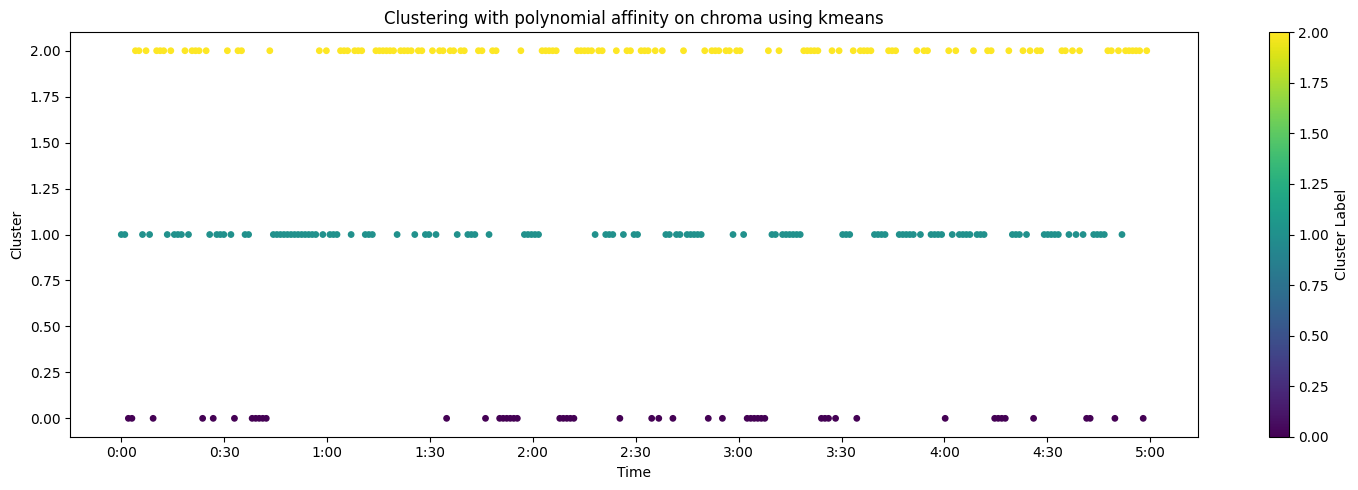

Timestamps for points in cluster 2:
4.12 seconds
5.15 seconds
7.22 seconds
10.31 seconds
11.34 seconds
12.37 seconds
14.43 seconds
18.56 seconds
20.62 seconds
21.65 seconds
22.68 seconds
24.74 seconds
30.93 seconds
34.02 seconds
35.05 seconds
43.30 seconds
57.73 seconds
59.79 seconds
63.92 seconds
64.95 seconds
65.98 seconds
68.04 seconds
69.07 seconds
70.10 seconds
74.23 seconds
75.26 seconds
76.29 seconds
77.32 seconds
78.35 seconds
79.38 seconds
81.44 seconds
82.47 seconds
83.51 seconds
84.54 seconds
86.60 seconds
87.63 seconds
90.72 seconds
92.78 seconds
93.81 seconds
95.88 seconds
96.91 seconds
98.97 seconds
100.00 seconds
104.12 seconds
105.15 seconds
108.25 seconds
109.28 seconds
116.49 seconds
122.68 seconds
123.71 seconds
124.74 seconds
125.77 seconds
126.80 seconds
132.99 seconds
134.02 seconds
135.05 seconds
136.08 seconds
137.11 seconds
139.18 seconds
140.21 seconds
144.33 seconds
147.42 seconds
148.45 seconds
151.55 seconds
152.58 seconds
153.61 seconds
155.67 seconds
157.

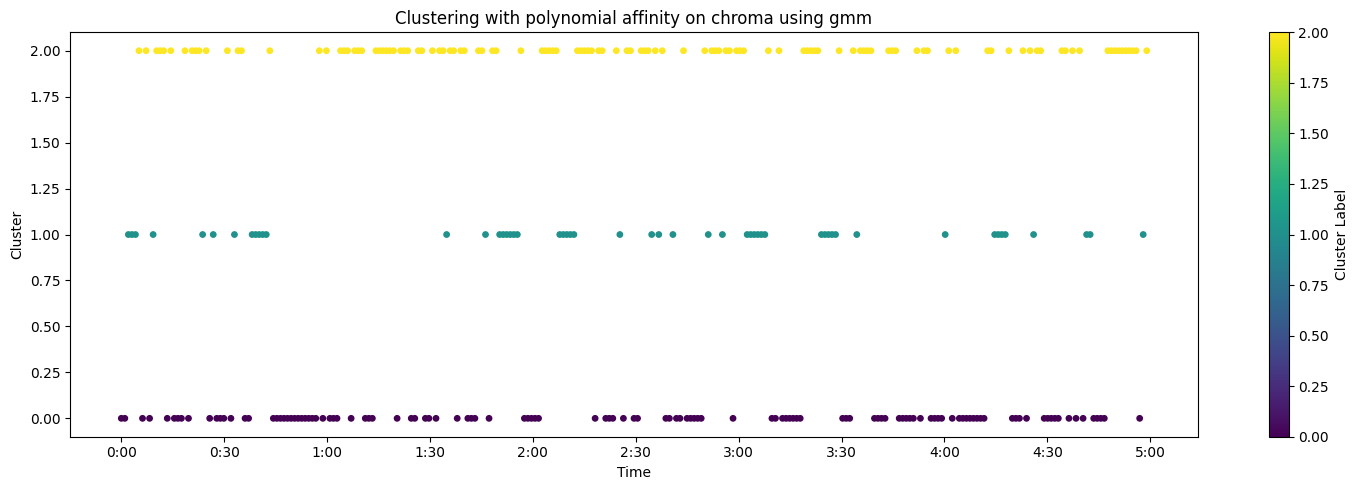

Timestamps for points in cluster 2:
5.15 seconds
7.22 seconds
10.31 seconds
11.34 seconds
12.37 seconds
14.43 seconds
18.56 seconds
20.62 seconds
21.65 seconds
22.68 seconds
24.74 seconds
30.93 seconds
34.02 seconds
35.05 seconds
43.30 seconds
57.73 seconds
59.79 seconds
63.92 seconds
64.95 seconds
65.98 seconds
68.04 seconds
69.07 seconds
70.10 seconds
74.23 seconds
75.26 seconds
76.29 seconds
77.32 seconds
78.35 seconds
79.38 seconds
81.44 seconds
82.47 seconds
83.51 seconds
86.60 seconds
87.63 seconds
90.72 seconds
92.78 seconds
93.81 seconds
95.88 seconds
96.91 seconds
98.97 seconds
100.00 seconds
104.12 seconds
105.15 seconds
108.25 seconds
109.28 seconds
116.49 seconds
122.68 seconds
123.71 seconds
124.74 seconds
125.77 seconds
126.80 seconds
132.99 seconds
134.02 seconds
135.05 seconds
136.08 seconds
137.11 seconds
139.18 seconds
140.21 seconds
144.33 seconds
147.42 seconds
148.45 seconds
151.55 seconds
152.58 seconds
153.61 seconds
155.67 seconds
157.73 seconds
163.92 seconds
1

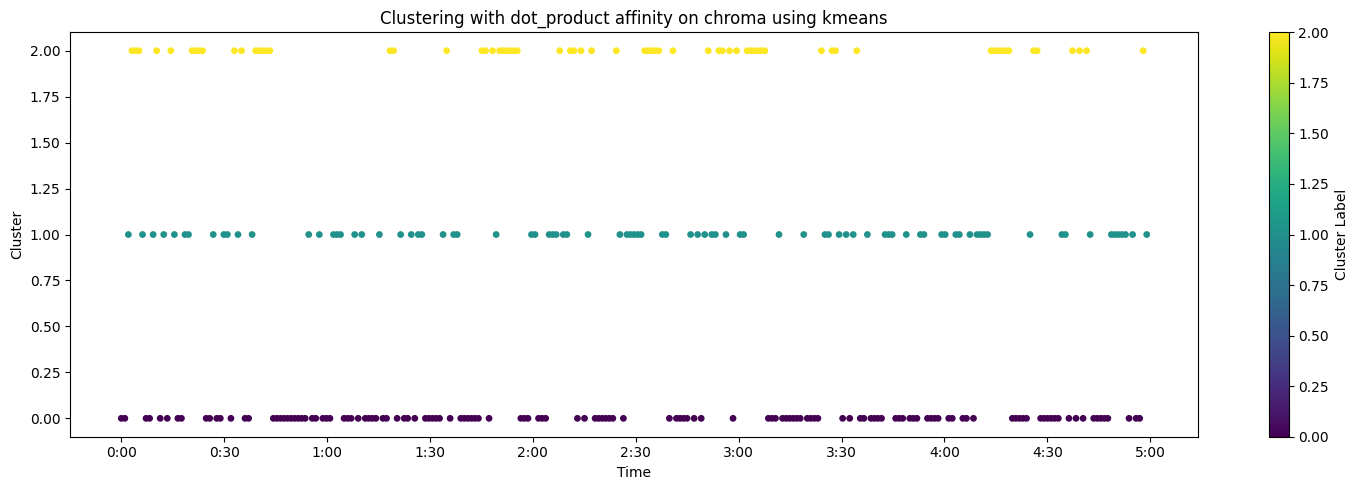

Timestamps for points in cluster 2:
3.09 seconds
4.12 seconds
5.15 seconds
10.31 seconds
14.43 seconds
20.62 seconds
21.65 seconds
22.68 seconds
23.71 seconds
32.99 seconds
35.05 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
43.30 seconds
78.35 seconds
79.38 seconds
94.85 seconds
105.15 seconds
106.19 seconds
108.25 seconds
110.31 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
127.84 seconds
130.93 seconds
131.96 seconds
134.02 seconds
137.11 seconds
144.33 seconds
152.58 seconds
153.61 seconds
154.64 seconds
155.67 seconds
156.70 seconds
160.82 seconds
171.13 seconds
174.23 seconds
175.26 seconds
177.32 seconds
179.38 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
204.12 seconds
207.22 seconds
208.25 seconds
214.43 seconds
253.61 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
258.76 seconds
265.98 seconds
267.01 seconds
277.32 seconds
279.38 seconds
281.44 seco

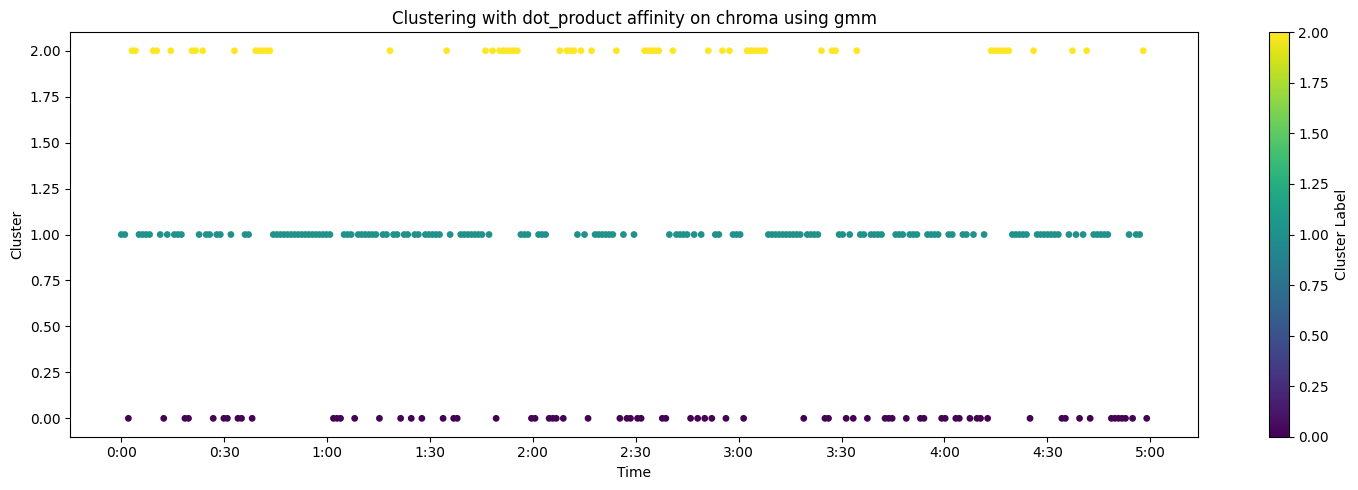

Timestamps for points in cluster 2:
3.09 seconds
4.12 seconds
9.28 seconds
10.31 seconds
14.43 seconds
20.62 seconds
21.65 seconds
23.71 seconds
32.99 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
43.30 seconds
78.35 seconds
94.85 seconds
106.19 seconds
108.25 seconds
110.31 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
127.84 seconds
129.90 seconds
130.93 seconds
131.96 seconds
134.02 seconds
137.11 seconds
144.33 seconds
152.58 seconds
153.61 seconds
154.64 seconds
155.67 seconds
156.70 seconds
160.82 seconds
171.13 seconds
175.26 seconds
177.32 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
204.12 seconds
207.22 seconds
208.25 seconds
214.43 seconds
253.61 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
258.76 seconds
265.98 seconds
277.32 seconds
281.44 seconds
297.94 seconds
60
Feature Set: chroma_scaled, Affinity: rbf, Method: kmeans, Silhouette: 0.1687766

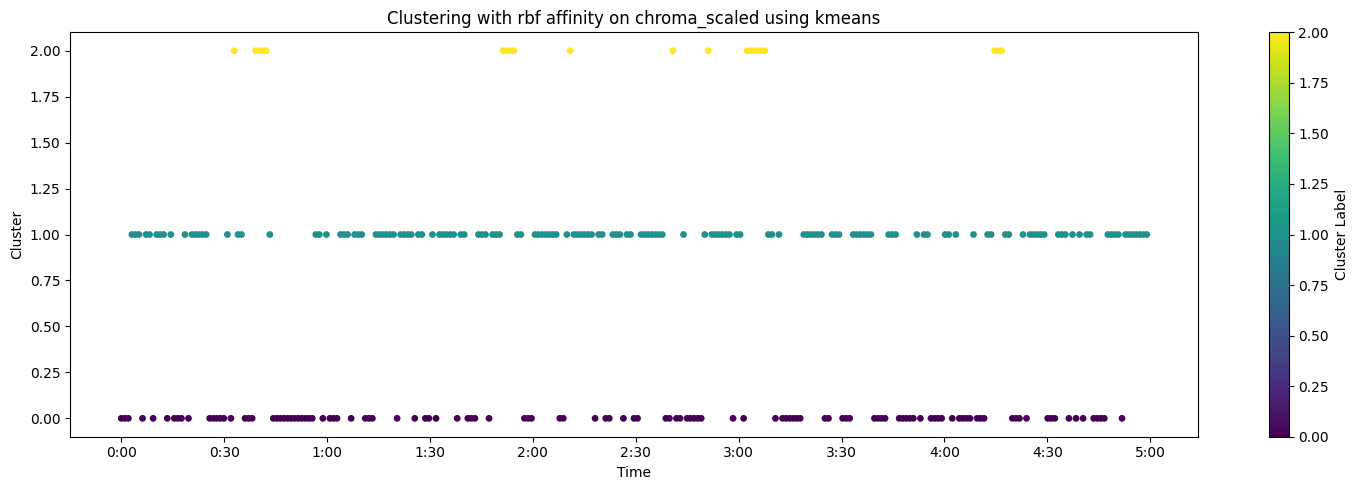

Timestamps for points in cluster 2:
32.99 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
130.93 seconds
160.82 seconds
171.13 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
254.64 seconds
255.67 seconds
256.70 seconds
21
Feature Set: chroma_scaled, Affinity: rbf, Method: gmm, Silhouette: 0.16660289398293776


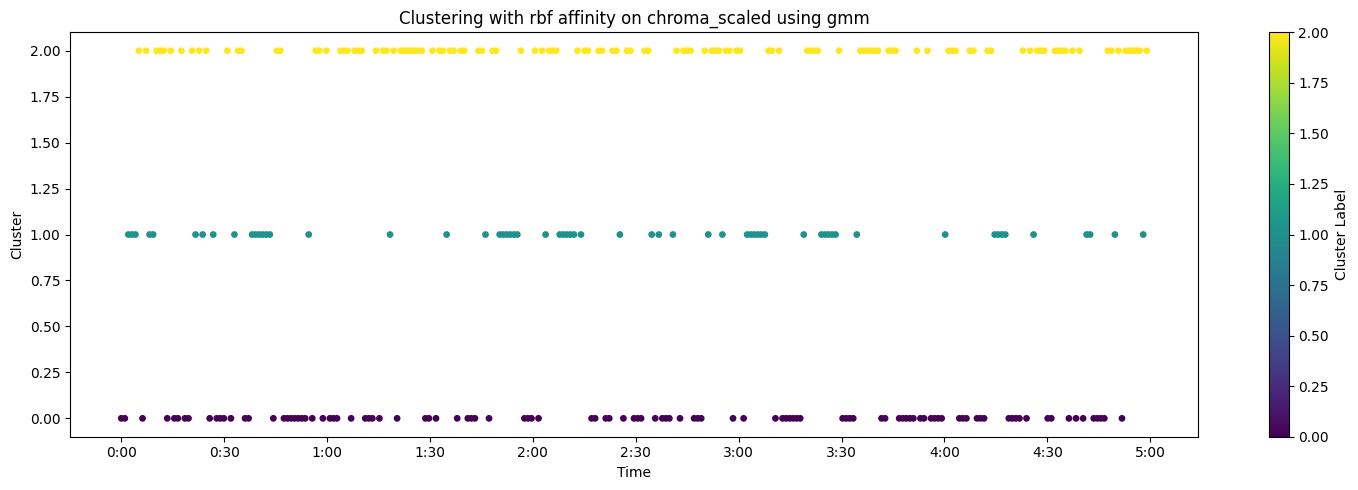

Timestamps for points in cluster 2:
5.15 seconds
7.22 seconds
10.31 seconds
11.34 seconds
12.37 seconds
14.43 seconds
17.53 seconds
20.62 seconds
22.68 seconds
24.74 seconds
30.93 seconds
34.02 seconds
35.05 seconds
45.36 seconds
46.39 seconds
56.70 seconds
57.73 seconds
59.79 seconds
63.92 seconds
64.95 seconds
65.98 seconds
68.04 seconds
69.07 seconds
70.10 seconds
74.23 seconds
76.29 seconds
77.32 seconds
79.38 seconds
81.44 seconds
82.47 seconds
83.51 seconds
84.54 seconds
85.57 seconds
86.60 seconds
87.63 seconds
90.72 seconds
92.78 seconds
93.81 seconds
95.88 seconds
96.91 seconds
98.97 seconds
100.00 seconds
104.12 seconds
105.15 seconds
108.25 seconds
109.28 seconds
116.49 seconds
120.62 seconds
122.68 seconds
124.74 seconds
125.77 seconds
126.80 seconds
132.99 seconds
135.05 seconds
136.08 seconds
139.18 seconds
140.21 seconds
143.30 seconds
144.33 seconds
147.42 seconds
148.45 seconds
152.58 seconds
153.61 seconds
161.86 seconds
163.92 seconds
164.95 seconds
165.98 seconds
17

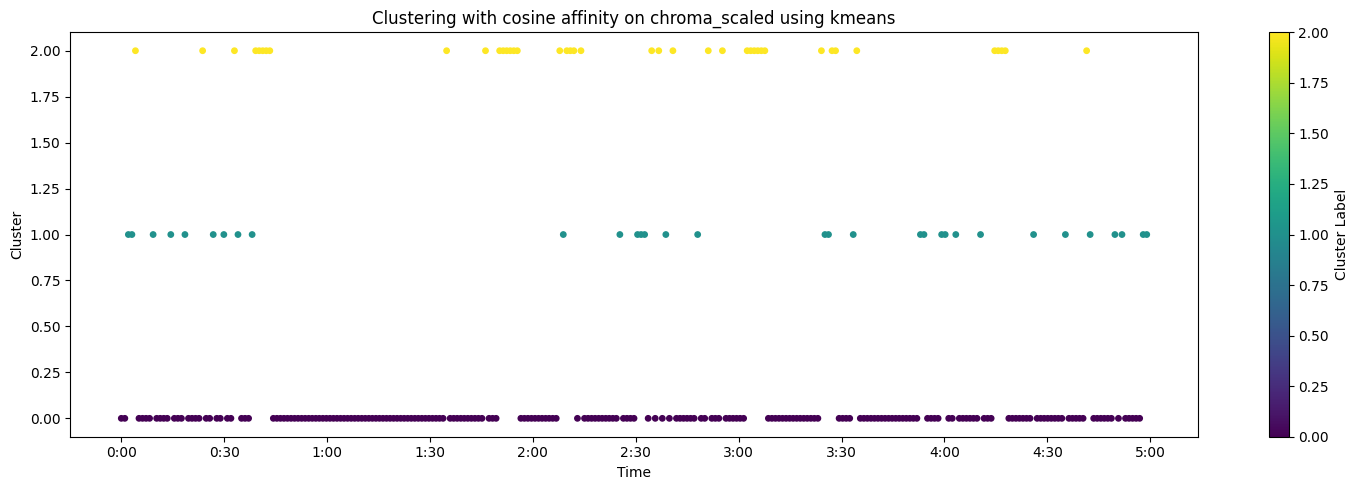

Timestamps for points in cluster 2:
4.12 seconds
23.71 seconds
32.99 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
43.30 seconds
94.85 seconds
106.19 seconds
110.31 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
127.84 seconds
129.90 seconds
130.93 seconds
131.96 seconds
134.02 seconds
154.64 seconds
156.70 seconds
160.82 seconds
171.13 seconds
175.26 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
204.12 seconds
207.22 seconds
208.25 seconds
214.43 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
281.44 seconds
41
Feature Set: chroma_scaled, Affinity: cosine, Method: gmm, Silhouette: 0.12660977661835174


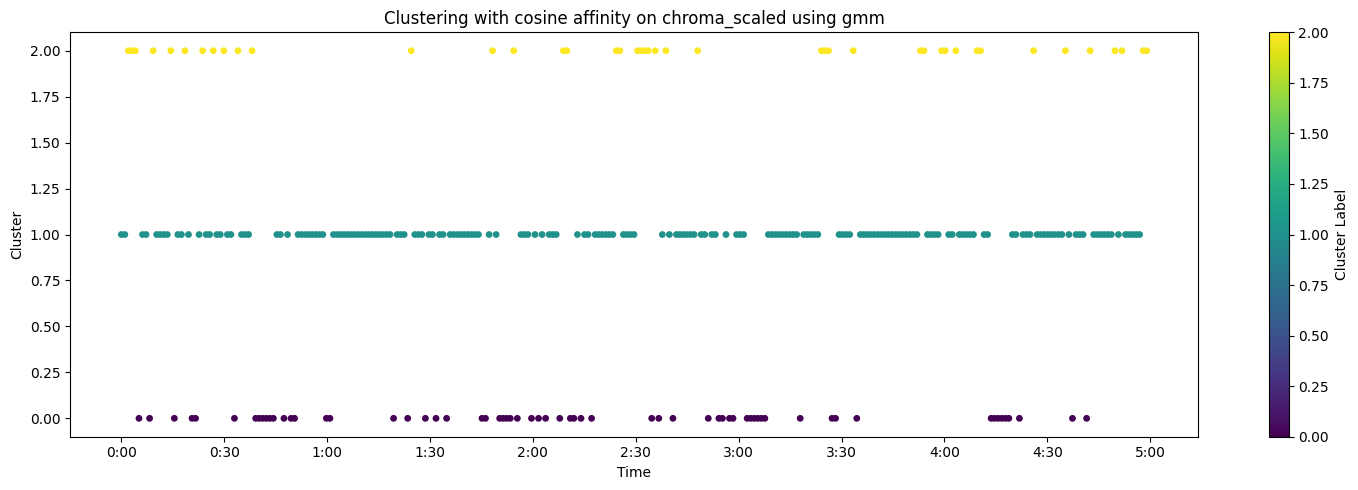

Timestamps for points in cluster 2:
2.06 seconds
3.09 seconds
4.12 seconds
9.28 seconds
14.43 seconds
18.56 seconds
23.71 seconds
26.80 seconds
29.90 seconds
34.02 seconds
38.14 seconds
84.54 seconds
108.25 seconds
114.43 seconds
128.87 seconds
129.90 seconds
144.33 seconds
145.36 seconds
150.52 seconds
151.55 seconds
152.58 seconds
153.61 seconds
155.67 seconds
158.76 seconds
168.04 seconds
204.12 seconds
205.15 seconds
206.19 seconds
213.40 seconds
232.99 seconds
234.02 seconds
239.18 seconds
240.21 seconds
243.30 seconds
249.48 seconds
250.52 seconds
265.98 seconds
275.26 seconds
282.47 seconds
289.69 seconds
291.75 seconds
297.94 seconds
298.97 seconds
43
Feature Set: chroma_scaled, Affinity: polynomial, Method: kmeans, Silhouette: 0.18288742387274998


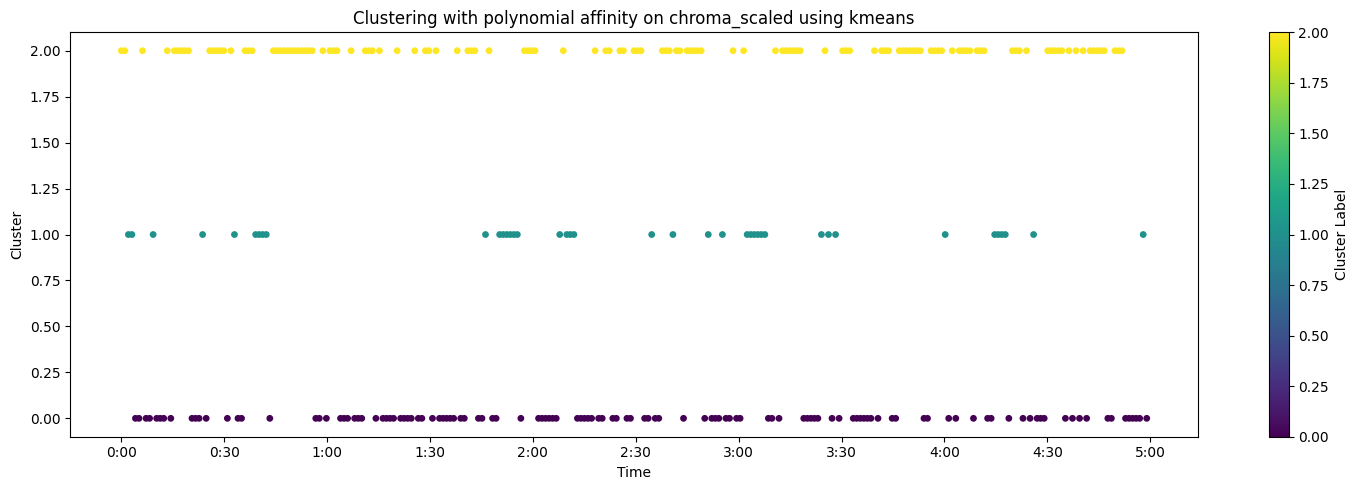

Timestamps for points in cluster 2:
0.00 seconds
1.03 seconds
6.19 seconds
13.40 seconds
15.46 seconds
16.49 seconds
17.53 seconds
18.56 seconds
19.59 seconds
25.77 seconds
26.80 seconds
27.84 seconds
28.87 seconds
29.90 seconds
31.96 seconds
36.08 seconds
37.11 seconds
38.14 seconds
44.33 seconds
45.36 seconds
46.39 seconds
47.42 seconds
48.45 seconds
49.48 seconds
50.52 seconds
51.55 seconds
52.58 seconds
53.61 seconds
54.64 seconds
55.67 seconds
58.76 seconds
60.82 seconds
61.86 seconds
62.89 seconds
67.01 seconds
71.13 seconds
72.16 seconds
73.20 seconds
75.26 seconds
80.41 seconds
85.57 seconds
88.66 seconds
89.69 seconds
91.75 seconds
97.94 seconds
101.03 seconds
102.06 seconds
103.09 seconds
107.22 seconds
117.53 seconds
118.56 seconds
119.59 seconds
120.62 seconds
128.87 seconds
138.14 seconds
141.24 seconds
142.27 seconds
145.36 seconds
146.39 seconds
149.48 seconds
150.52 seconds
151.55 seconds
157.73 seconds
158.76 seconds
159.79 seconds
161.86 seconds
162.89 seconds
164.95 

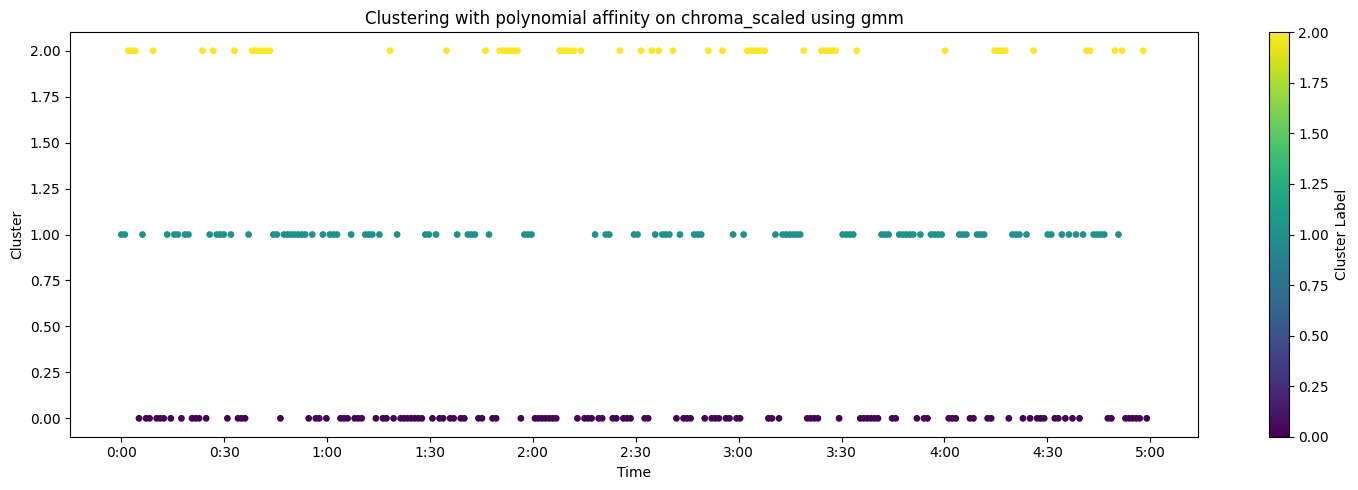

Timestamps for points in cluster 2:
2.06 seconds
3.09 seconds
4.12 seconds
9.28 seconds
23.71 seconds
26.80 seconds
32.99 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
43.30 seconds
78.35 seconds
94.85 seconds
106.19 seconds
110.31 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
127.84 seconds
128.87 seconds
129.90 seconds
130.93 seconds
131.96 seconds
134.02 seconds
145.36 seconds
151.55 seconds
154.64 seconds
156.70 seconds
160.82 seconds
171.13 seconds
175.26 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
198.97 seconds
204.12 seconds
205.15 seconds
206.19 seconds
207.22 seconds
208.25 seconds
214.43 seconds
240.21 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
265.98 seconds
281.44 seconds
282.47 seconds
289.69 seconds
291.75 seconds
297.94 seconds
59
Feature Set: chroma_scaled, Affinity: dot_product, Method: kmeans, Silhouette: 0.17610444147457

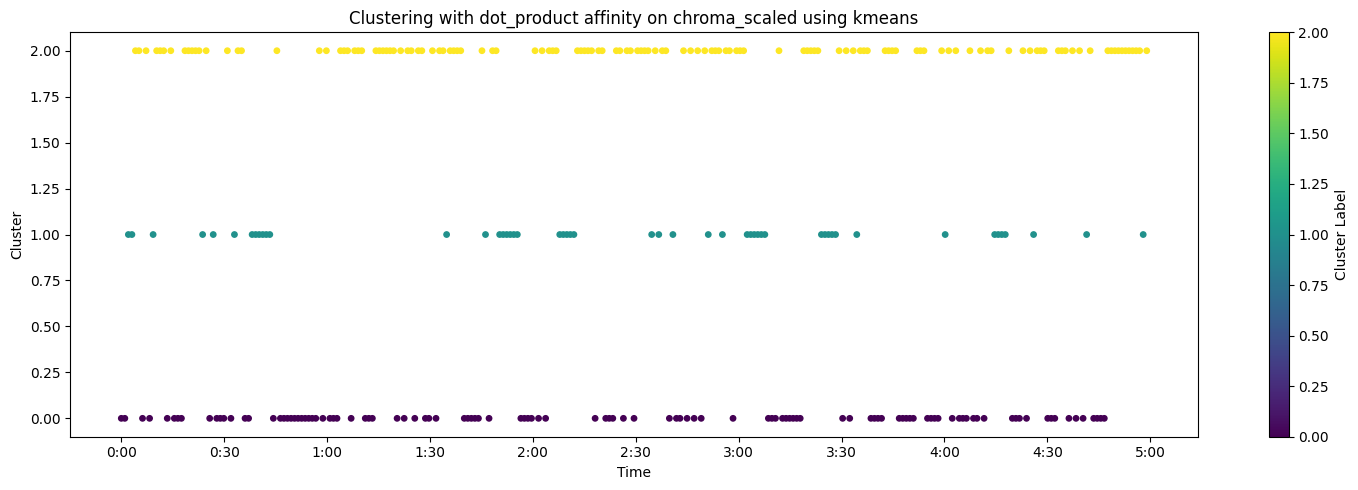

Timestamps for points in cluster 2:
4.12 seconds
5.15 seconds
7.22 seconds
10.31 seconds
11.34 seconds
12.37 seconds
14.43 seconds
18.56 seconds
19.59 seconds
20.62 seconds
21.65 seconds
22.68 seconds
24.74 seconds
30.93 seconds
34.02 seconds
35.05 seconds
45.36 seconds
57.73 seconds
59.79 seconds
63.92 seconds
64.95 seconds
65.98 seconds
68.04 seconds
69.07 seconds
70.10 seconds
74.23 seconds
75.26 seconds
76.29 seconds
77.32 seconds
78.35 seconds
79.38 seconds
81.44 seconds
83.51 seconds
84.54 seconds
86.60 seconds
87.63 seconds
90.72 seconds
92.78 seconds
93.81 seconds
95.88 seconds
96.91 seconds
97.94 seconds
98.97 seconds
105.15 seconds
108.25 seconds
109.28 seconds
120.62 seconds
122.68 seconds
124.74 seconds
125.77 seconds
126.80 seconds
132.99 seconds
134.02 seconds
135.05 seconds
136.08 seconds
137.11 seconds
139.18 seconds
140.21 seconds
144.33 seconds
145.36 seconds
147.42 seconds
148.45 seconds
150.52 seconds
151.55 seconds
152.58 seconds
153.61 seconds
155.67 seconds
157.7

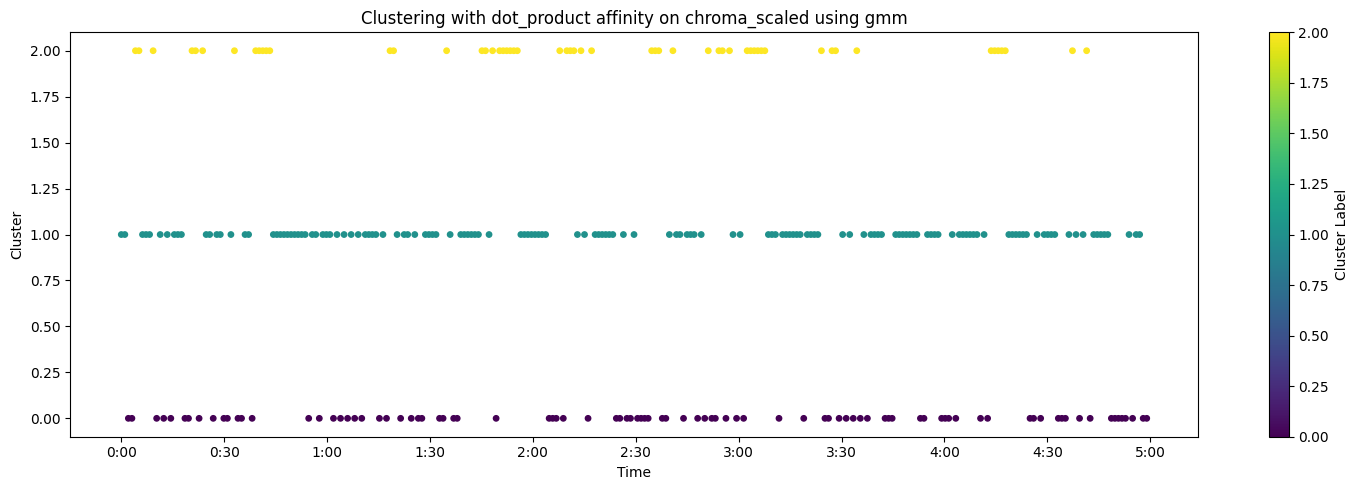

Timestamps for points in cluster 2:
4.12 seconds
5.15 seconds
9.28 seconds
20.62 seconds
21.65 seconds
23.71 seconds
32.99 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
43.30 seconds
78.35 seconds
79.38 seconds
94.85 seconds
105.15 seconds
106.19 seconds
108.25 seconds
110.31 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
127.84 seconds
129.90 seconds
130.93 seconds
131.96 seconds
134.02 seconds
137.11 seconds
154.64 seconds
155.67 seconds
156.70 seconds
160.82 seconds
171.13 seconds
174.23 seconds
175.26 seconds
177.32 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
204.12 seconds
207.22 seconds
208.25 seconds
214.43 seconds
253.61 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
277.32 seconds
281.44 seconds
55
Feature Set: mfccs_delta, Affinity: rbf, Method: kmeans, Silhouette: 0.7799527859997735


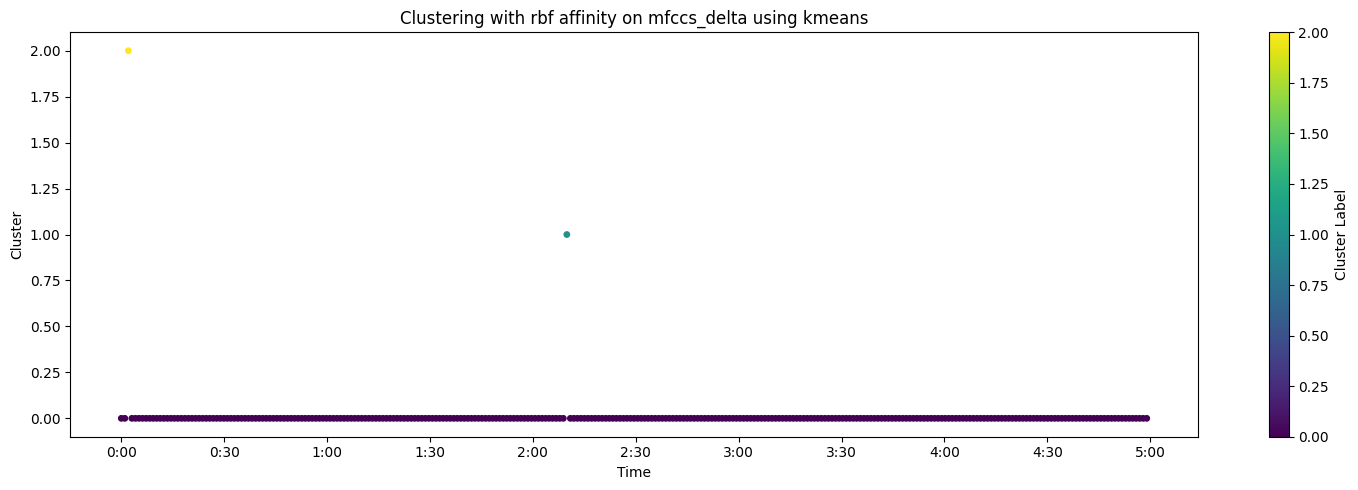

Timestamps for points in cluster 2:
2.06 seconds
1
Feature Set: mfccs_delta, Affinity: rbf, Method: gmm, Silhouette: 0.7799527859997735


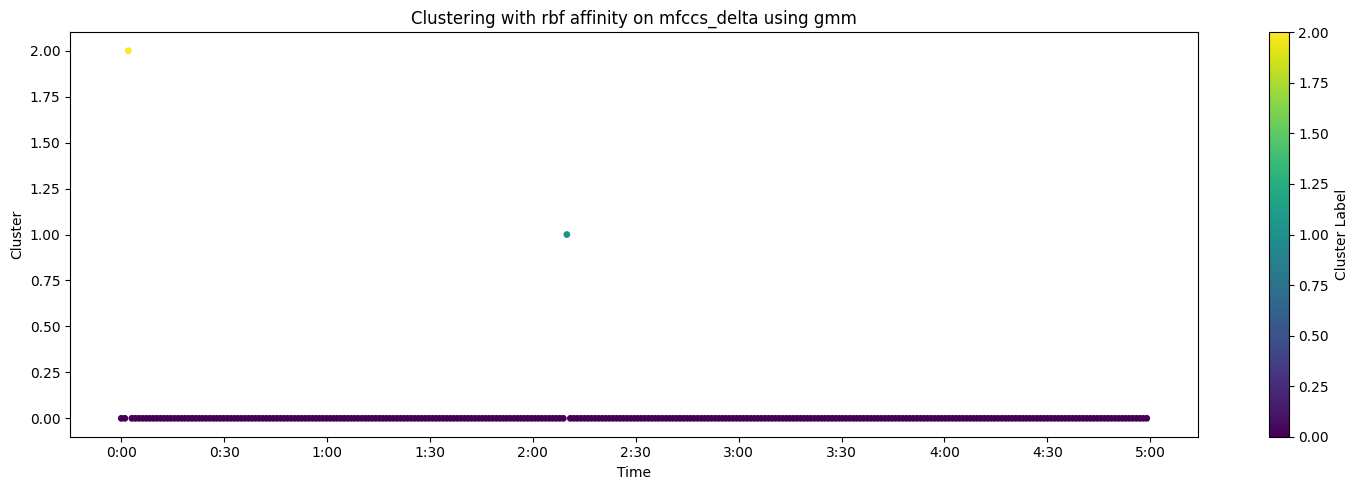

Timestamps for points in cluster 2:
2.06 seconds
1
Feature Set: mfccs_delta, Affinity: cosine, Method: kmeans, Silhouette: 0.6134610498858238


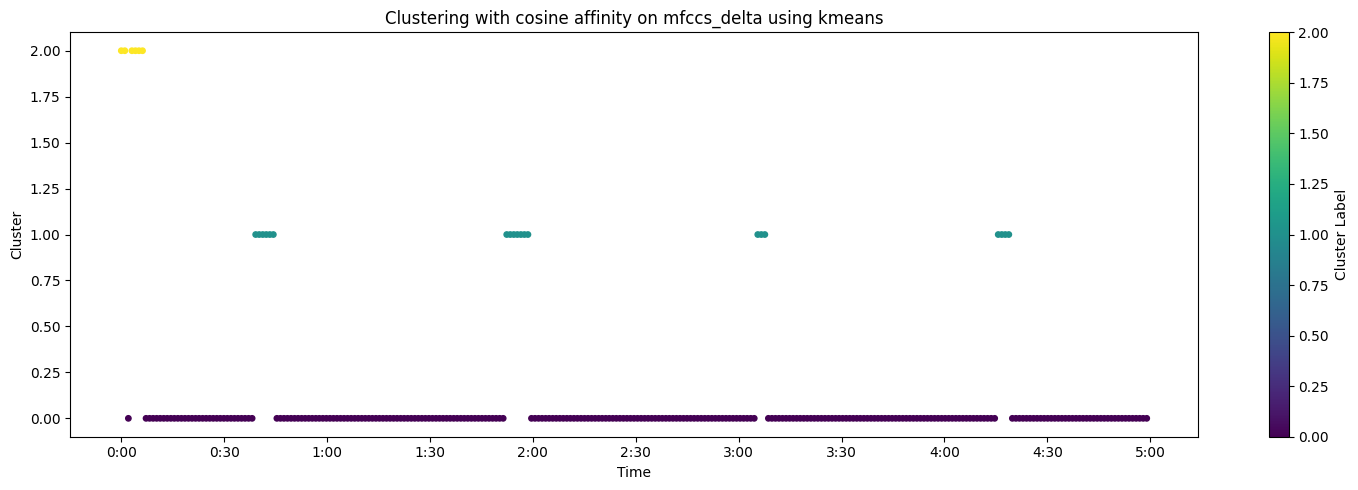

Timestamps for points in cluster 2:
0.00 seconds
1.03 seconds
3.09 seconds
4.12 seconds
5.15 seconds
6.19 seconds
6
Feature Set: mfccs_delta, Affinity: cosine, Method: gmm, Silhouette: 0.634115292151621


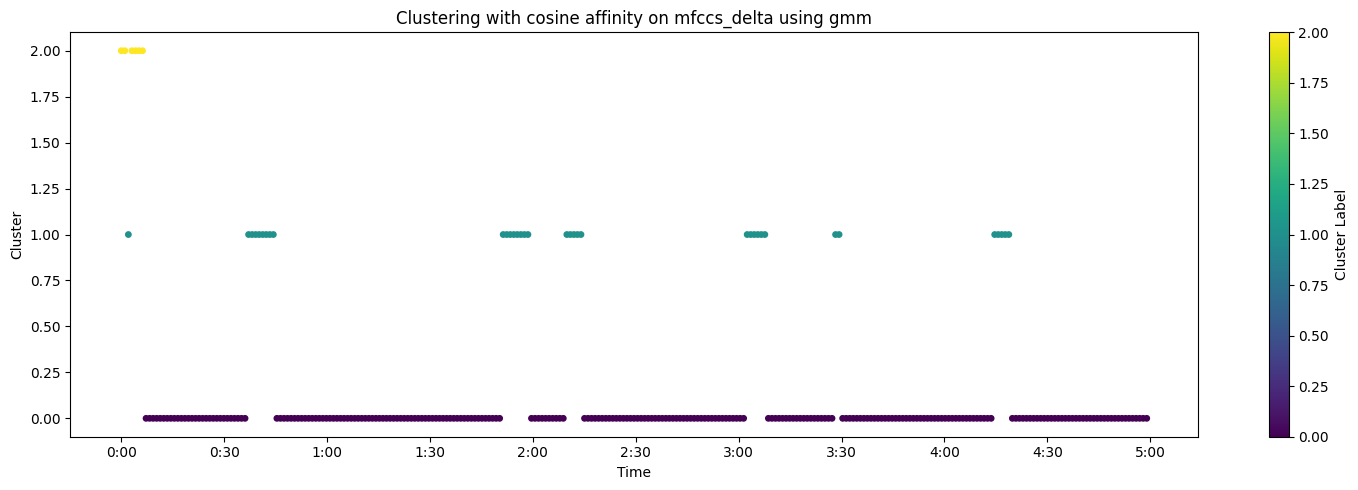

Timestamps for points in cluster 2:
0.00 seconds
1.03 seconds
3.09 seconds
4.12 seconds
5.15 seconds
6.19 seconds
6
Feature Set: mfccs_delta, Affinity: polynomial, Method: kmeans, Silhouette: 0.7970857109213457


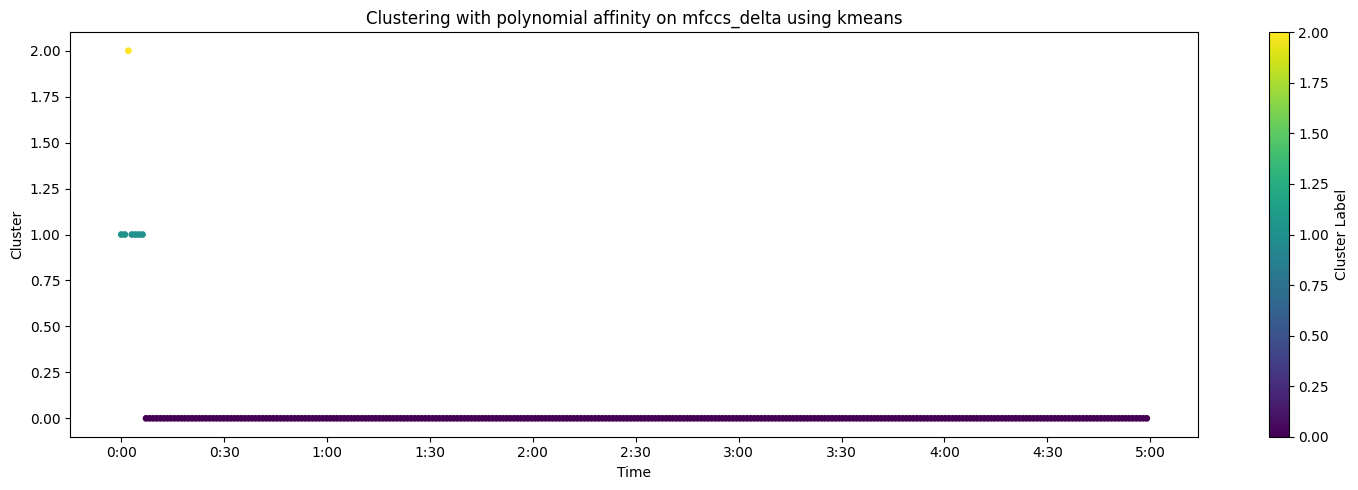

Timestamps for points in cluster 2:
2.06 seconds
1
Feature Set: mfccs_delta, Affinity: polynomial, Method: gmm, Silhouette: 0.7970857109213457


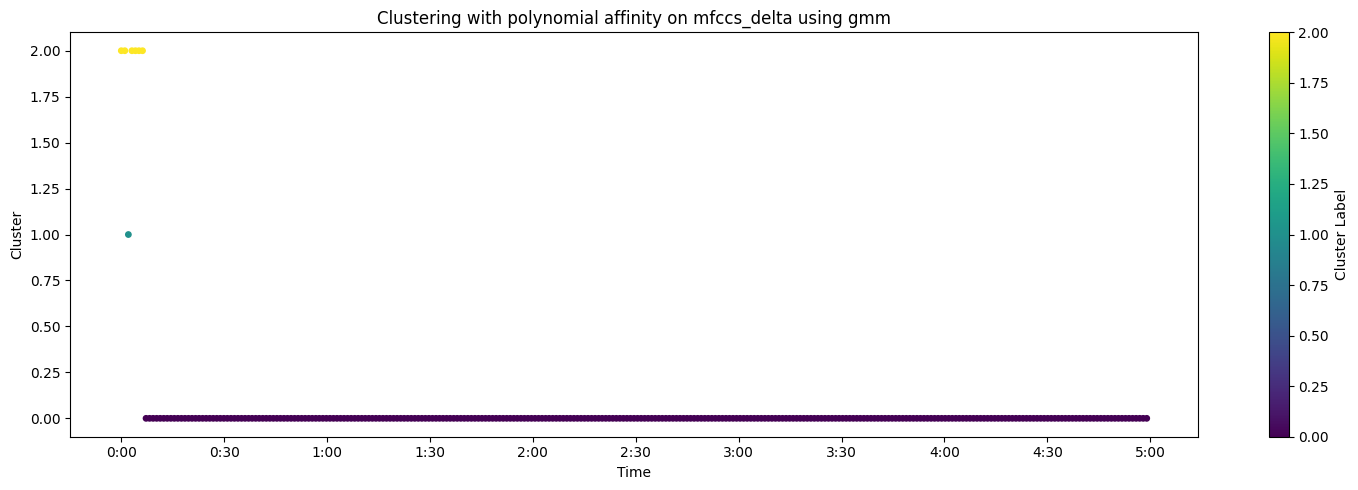

Timestamps for points in cluster 2:
0.00 seconds
1.03 seconds
3.09 seconds
4.12 seconds
5.15 seconds
6.19 seconds
6
Feature Set: mfccs_delta, Affinity: dot_product, Method: kmeans, Silhouette: 0.7970857109213457


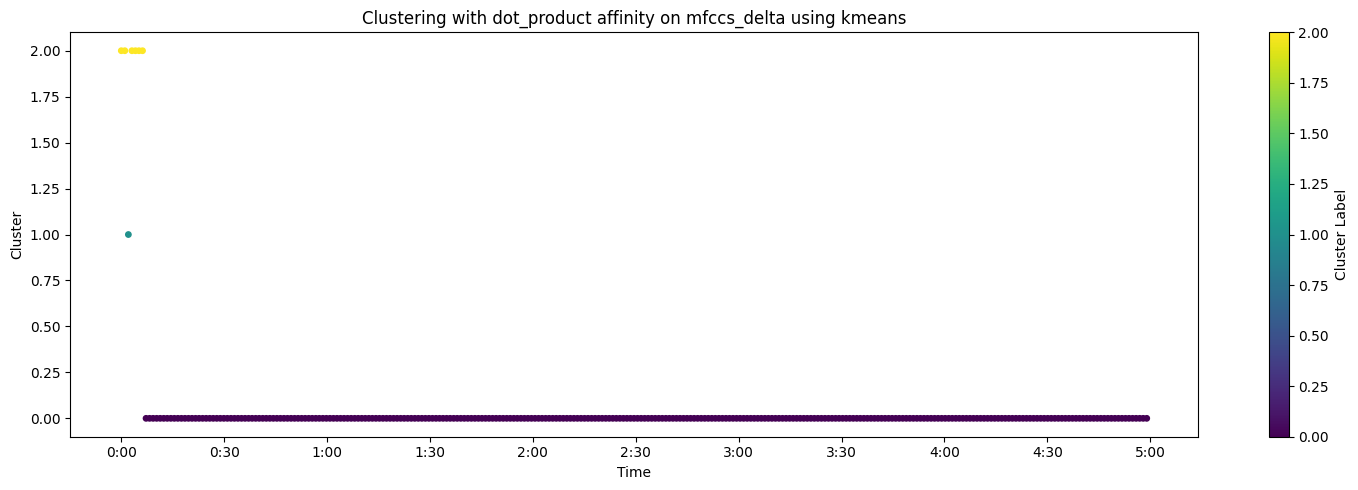

Timestamps for points in cluster 2:
0.00 seconds
1.03 seconds
3.09 seconds
4.12 seconds
5.15 seconds
6.19 seconds
6
Feature Set: mfccs_delta, Affinity: dot_product, Method: gmm, Silhouette: 0.7970857109213457


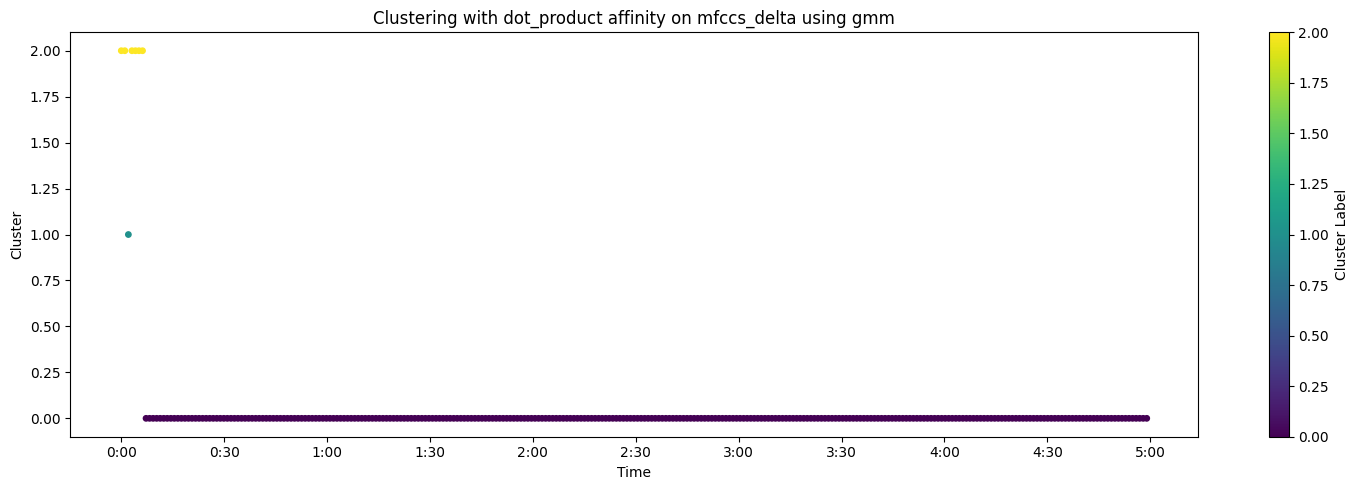

Timestamps for points in cluster 2:
0.00 seconds
1.03 seconds
3.09 seconds
4.12 seconds
5.15 seconds
6.19 seconds
6
Feature Set: mfccs_chroma, Affinity: rbf, Method: kmeans, Silhouette: 0.7527061898957289


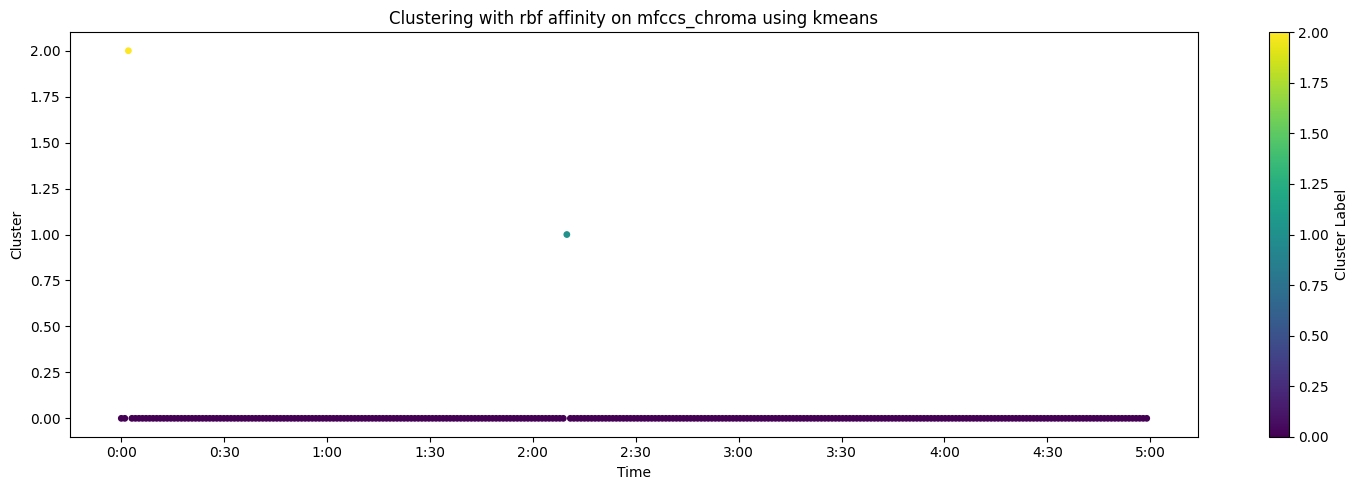

Timestamps for points in cluster 2:
2.06 seconds
1
Feature Set: mfccs_chroma, Affinity: rbf, Method: gmm, Silhouette: 0.7527061898957289


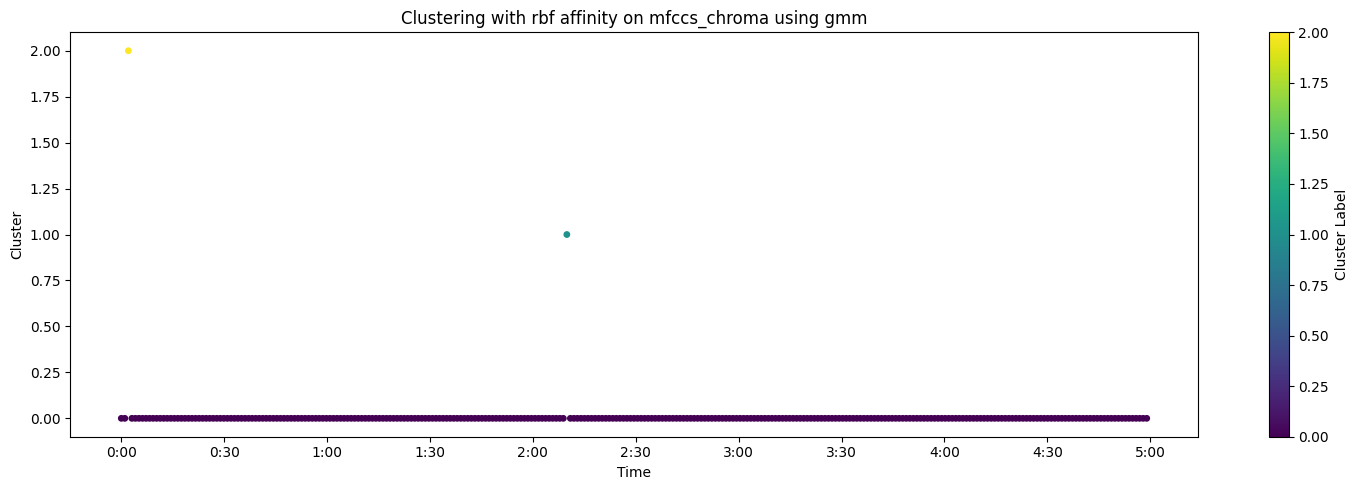

Timestamps for points in cluster 2:
2.06 seconds
1
Feature Set: mfccs_chroma, Affinity: cosine, Method: kmeans, Silhouette: 0.1487173406187139


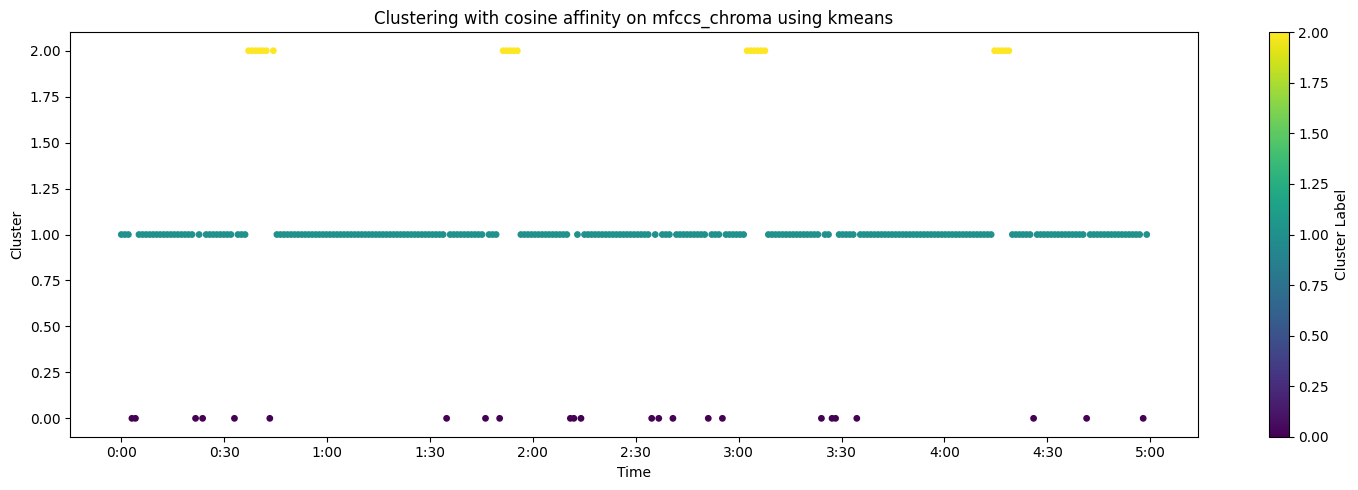

Timestamps for points in cluster 2:
37.11 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
44.33 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
258.76 seconds
23
Feature Set: mfccs_chroma, Affinity: cosine, Method: gmm, Silhouette: 0.19148770549940253


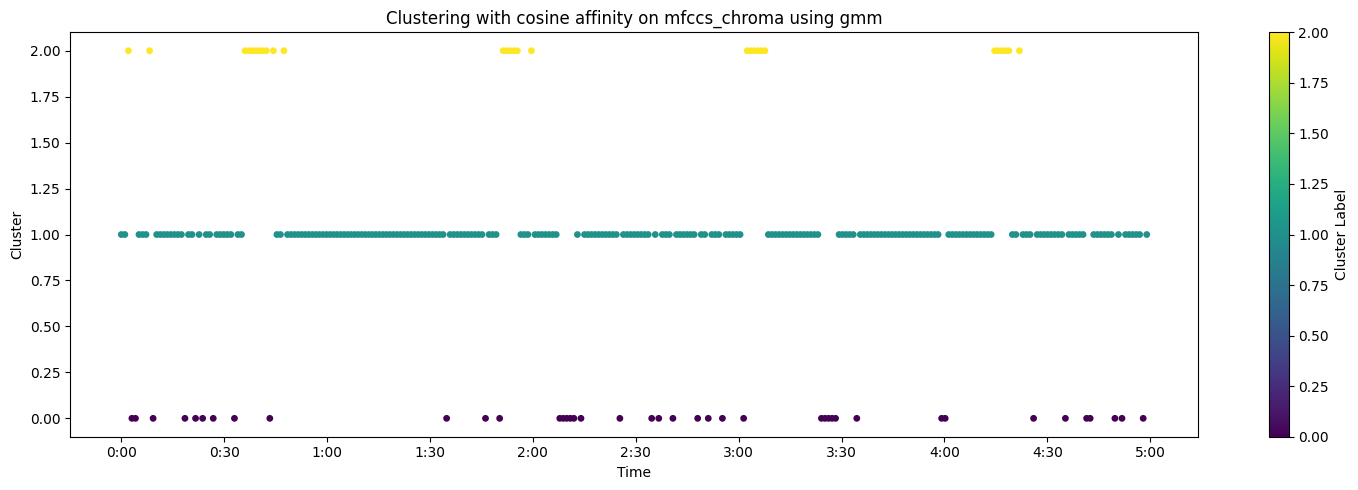

Timestamps for points in cluster 2:
2.06 seconds
8.25 seconds
36.08 seconds
37.11 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
44.33 seconds
47.42 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
119.59 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
258.76 seconds
261.86 seconds
29
Feature Set: mfccs_chroma, Affinity: polynomial, Method: kmeans, Silhouette: 0.7527061898957289


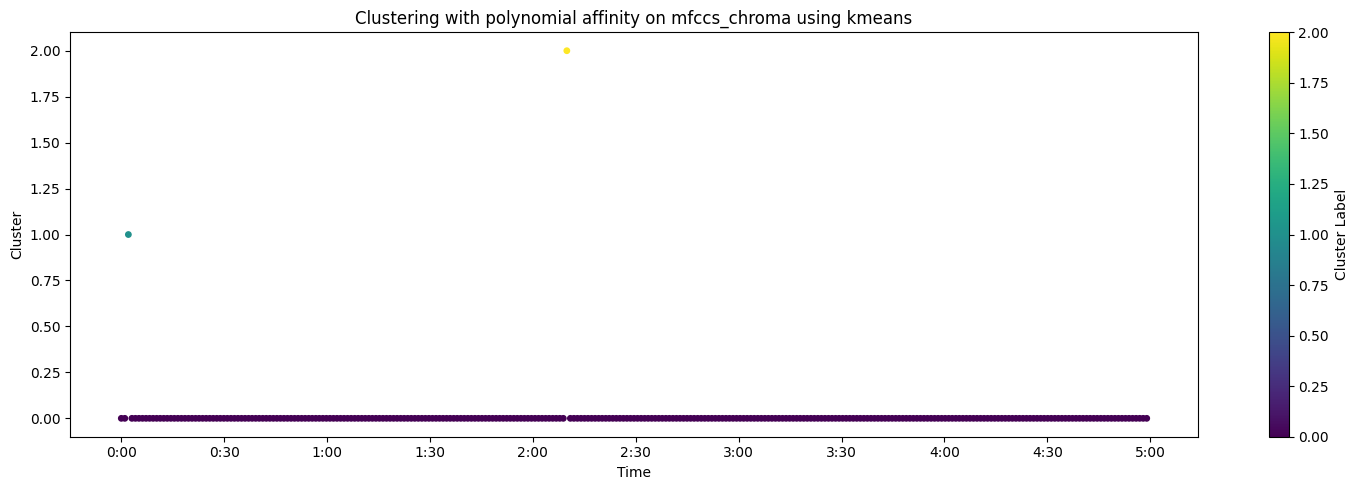

Timestamps for points in cluster 2:
129.90 seconds
1
Feature Set: mfccs_chroma, Affinity: polynomial, Method: gmm, Silhouette: 0.7527061898957289


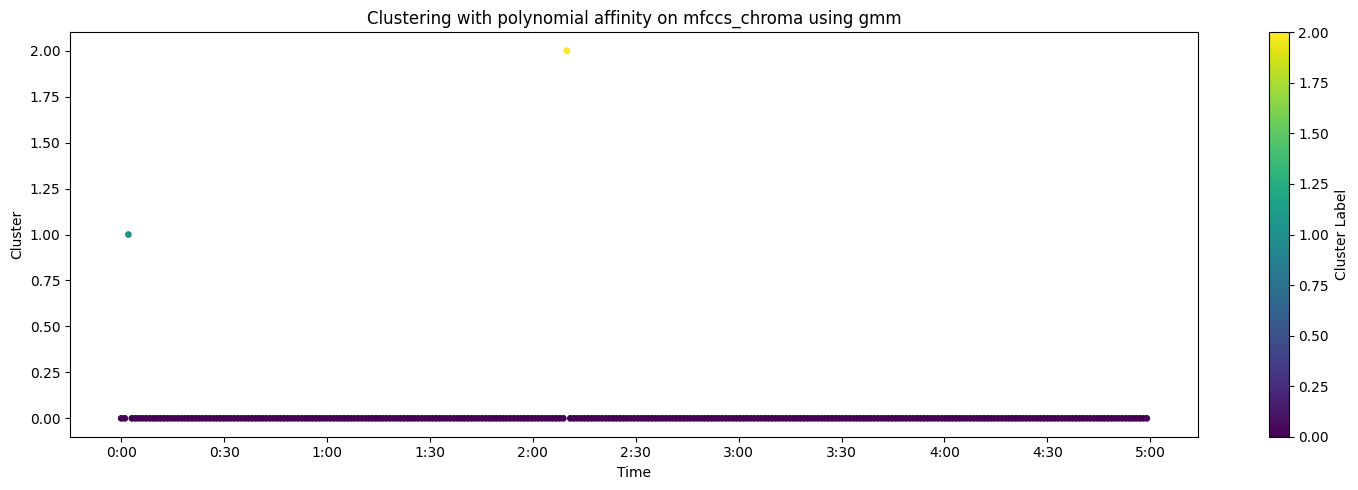

Timestamps for points in cluster 2:
129.90 seconds
1
Feature Set: mfccs_chroma, Affinity: dot_product, Method: kmeans, Silhouette: 0.5115719807233076


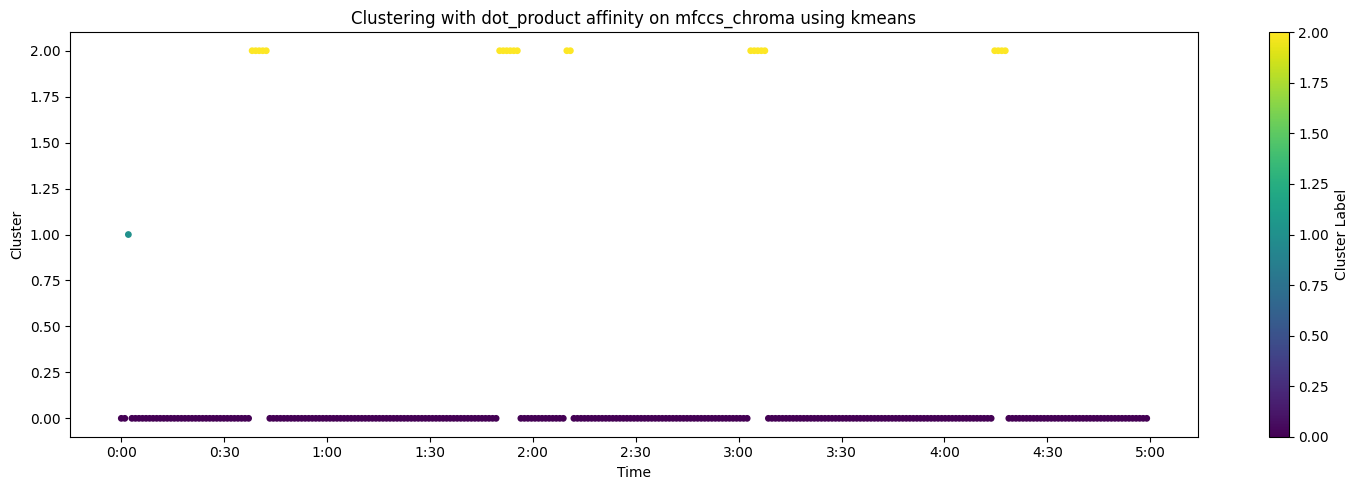

Timestamps for points in cluster 2:
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
110.31 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
129.90 seconds
130.93 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
22
Feature Set: mfccs_chroma, Affinity: dot_product, Method: gmm, Silhouette: 0.44335512294477586


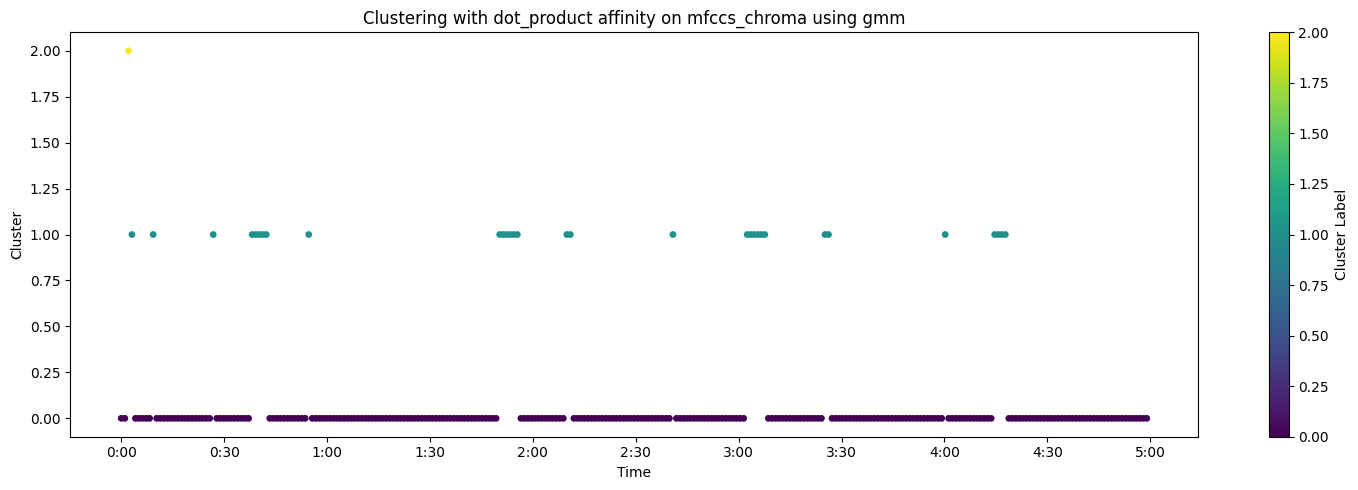

Timestamps for points in cluster 2:
2.06 seconds
1
Feature Set: chroma_spectral, Affinity: rbf, Method: kmeans, Silhouette: 0.1382384509321222


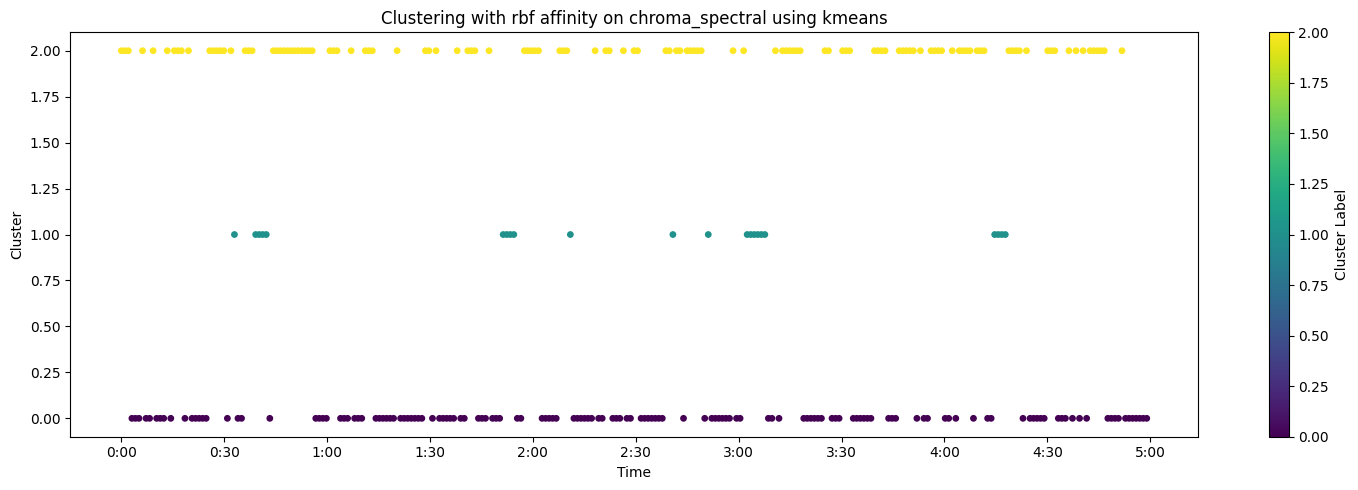

Timestamps for points in cluster 2:
0.00 seconds
1.03 seconds
2.06 seconds
6.19 seconds
9.28 seconds
13.40 seconds
15.46 seconds
16.49 seconds
17.53 seconds
19.59 seconds
25.77 seconds
26.80 seconds
27.84 seconds
28.87 seconds
29.90 seconds
31.96 seconds
36.08 seconds
37.11 seconds
38.14 seconds
44.33 seconds
45.36 seconds
46.39 seconds
47.42 seconds
48.45 seconds
49.48 seconds
50.52 seconds
51.55 seconds
52.58 seconds
53.61 seconds
54.64 seconds
55.67 seconds
60.82 seconds
61.86 seconds
62.89 seconds
67.01 seconds
71.13 seconds
72.16 seconds
73.20 seconds
80.41 seconds
88.66 seconds
89.69 seconds
91.75 seconds
97.94 seconds
101.03 seconds
102.06 seconds
103.09 seconds
107.22 seconds
117.53 seconds
118.56 seconds
119.59 seconds
120.62 seconds
121.65 seconds
127.84 seconds
128.87 seconds
129.90 seconds
138.14 seconds
141.24 seconds
142.27 seconds
146.39 seconds
149.48 seconds
150.52 seconds
158.76 seconds
159.79 seconds
161.86 seconds
162.89 seconds
164.95 seconds
165.98 seconds
167.01 

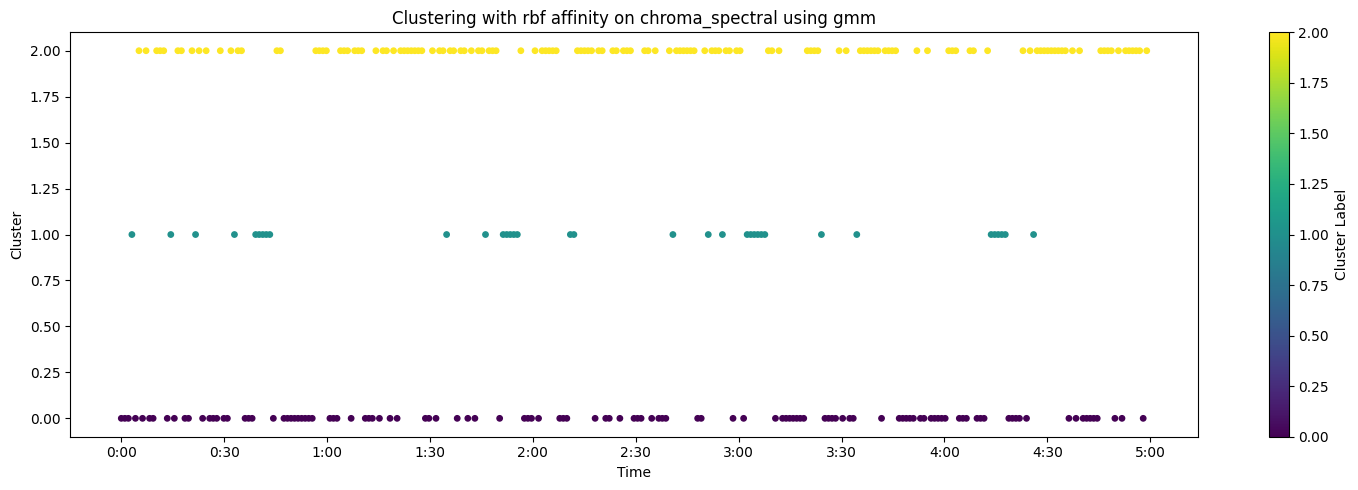

Timestamps for points in cluster 2:
5.15 seconds
7.22 seconds
10.31 seconds
11.34 seconds
12.37 seconds
16.49 seconds
17.53 seconds
20.62 seconds
22.68 seconds
24.74 seconds
28.87 seconds
31.96 seconds
34.02 seconds
35.05 seconds
45.36 seconds
46.39 seconds
56.70 seconds
57.73 seconds
58.76 seconds
59.79 seconds
63.92 seconds
64.95 seconds
65.98 seconds
68.04 seconds
69.07 seconds
70.10 seconds
74.23 seconds
76.29 seconds
77.32 seconds
79.38 seconds
81.44 seconds
82.47 seconds
83.51 seconds
84.54 seconds
85.57 seconds
86.60 seconds
87.63 seconds
90.72 seconds
92.78 seconds
93.81 seconds
95.88 seconds
96.91 seconds
98.97 seconds
100.00 seconds
102.06 seconds
104.12 seconds
105.15 seconds
107.22 seconds
108.25 seconds
109.28 seconds
116.49 seconds
120.62 seconds
122.68 seconds
123.71 seconds
124.74 seconds
125.77 seconds
126.80 seconds
132.99 seconds
134.02 seconds
135.05 seconds
136.08 seconds
137.11 seconds
139.18 seconds
140.21 seconds
143.30 seconds
144.33 seconds
146.39 seconds
147.

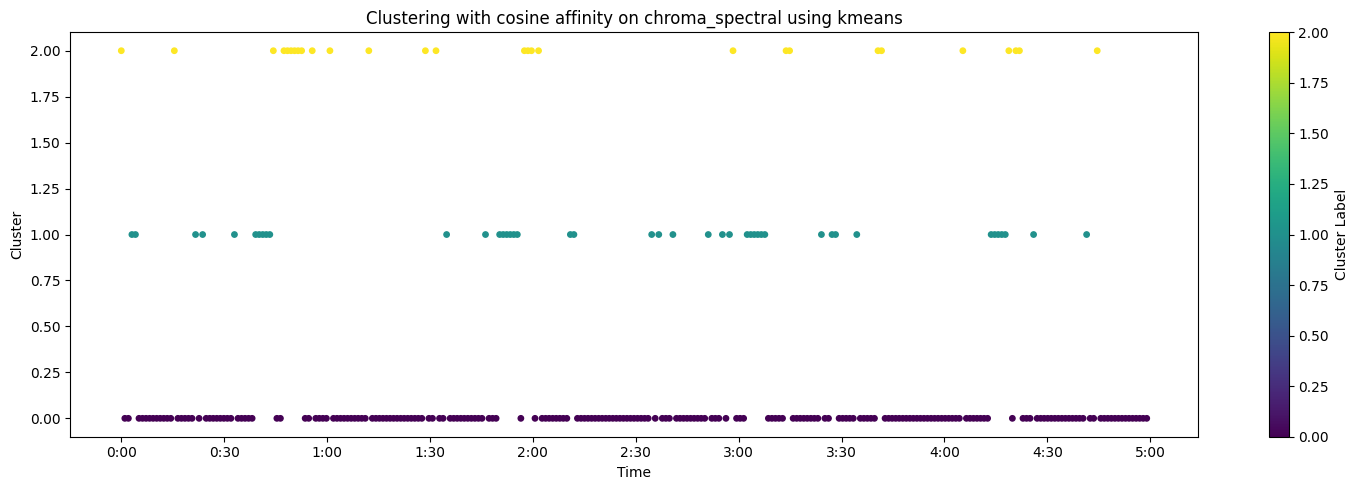

Timestamps for points in cluster 2:
0.00 seconds
15.46 seconds
44.33 seconds
47.42 seconds
48.45 seconds
49.48 seconds
50.52 seconds
51.55 seconds
52.58 seconds
55.67 seconds
60.82 seconds
72.16 seconds
88.66 seconds
91.75 seconds
117.53 seconds
118.56 seconds
119.59 seconds
121.65 seconds
178.35 seconds
193.81 seconds
194.85 seconds
220.62 seconds
221.65 seconds
245.36 seconds
258.76 seconds
260.82 seconds
261.86 seconds
284.54 seconds
28
Feature Set: chroma_spectral, Affinity: cosine, Method: gmm, Silhouette: 0.1186117533126783


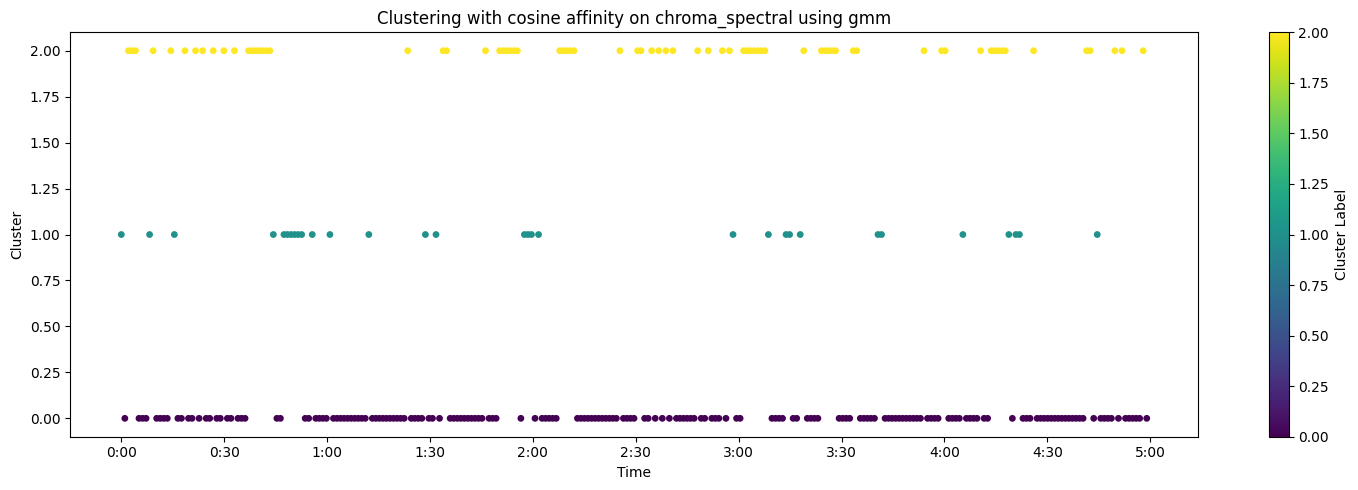

Timestamps for points in cluster 2:
2.06 seconds
3.09 seconds
4.12 seconds
9.28 seconds
14.43 seconds
18.56 seconds
21.65 seconds
23.71 seconds
26.80 seconds
29.90 seconds
32.99 seconds
37.11 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
43.30 seconds
83.51 seconds
93.81 seconds
94.85 seconds
106.19 seconds
110.31 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
127.84 seconds
128.87 seconds
129.90 seconds
130.93 seconds
131.96 seconds
145.36 seconds
150.52 seconds
151.55 seconds
154.64 seconds
156.70 seconds
158.76 seconds
160.82 seconds
168.04 seconds
171.13 seconds
175.26 seconds
177.32 seconds
181.44 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
198.97 seconds
204.12 seconds
205.15 seconds
206.19 seconds
207.22 seconds
208.25 seconds
213.40 seconds
214.43 seconds
234.02 seconds
239.18 seconds
240.21 seconds
250.52 seconds
253.61 seconds
254.64 seconds
255.67 seconds

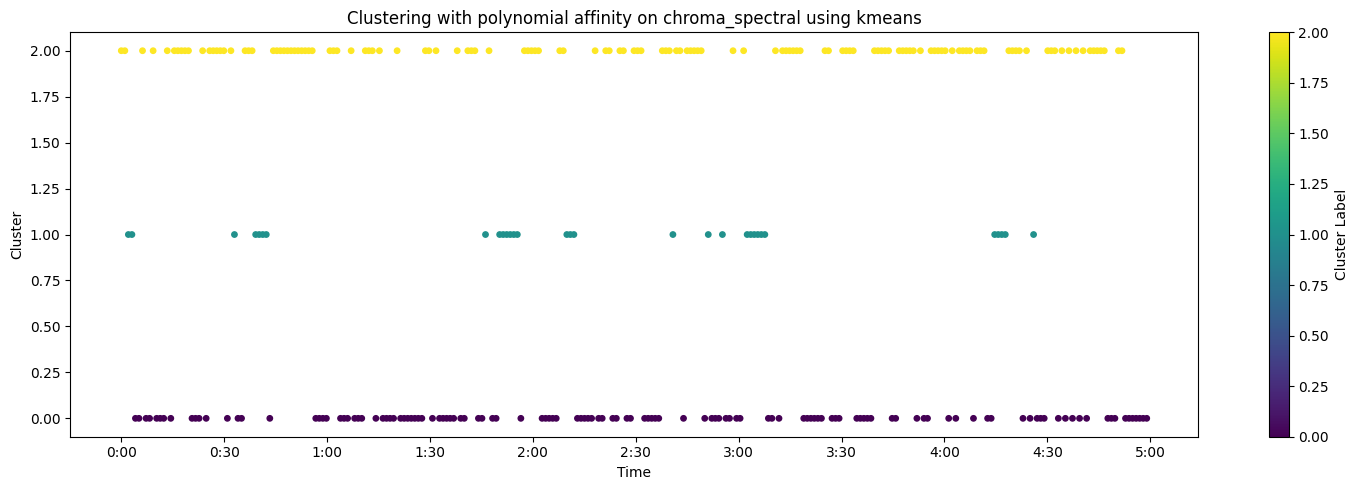

Timestamps for points in cluster 2:
0.00 seconds
1.03 seconds
6.19 seconds
9.28 seconds
13.40 seconds
15.46 seconds
16.49 seconds
17.53 seconds
18.56 seconds
19.59 seconds
23.71 seconds
25.77 seconds
26.80 seconds
27.84 seconds
28.87 seconds
29.90 seconds
31.96 seconds
36.08 seconds
37.11 seconds
38.14 seconds
44.33 seconds
45.36 seconds
46.39 seconds
47.42 seconds
48.45 seconds
49.48 seconds
50.52 seconds
51.55 seconds
52.58 seconds
53.61 seconds
54.64 seconds
55.67 seconds
60.82 seconds
61.86 seconds
62.89 seconds
67.01 seconds
71.13 seconds
72.16 seconds
73.20 seconds
75.26 seconds
80.41 seconds
88.66 seconds
89.69 seconds
91.75 seconds
97.94 seconds
101.03 seconds
102.06 seconds
103.09 seconds
107.22 seconds
117.53 seconds
118.56 seconds
119.59 seconds
120.62 seconds
121.65 seconds
127.84 seconds
128.87 seconds
138.14 seconds
141.24 seconds
142.27 seconds
145.36 seconds
146.39 seconds
149.48 seconds
150.52 seconds
151.55 seconds
157.73 seconds
158.76 seconds
159.79 seconds
161.86 s

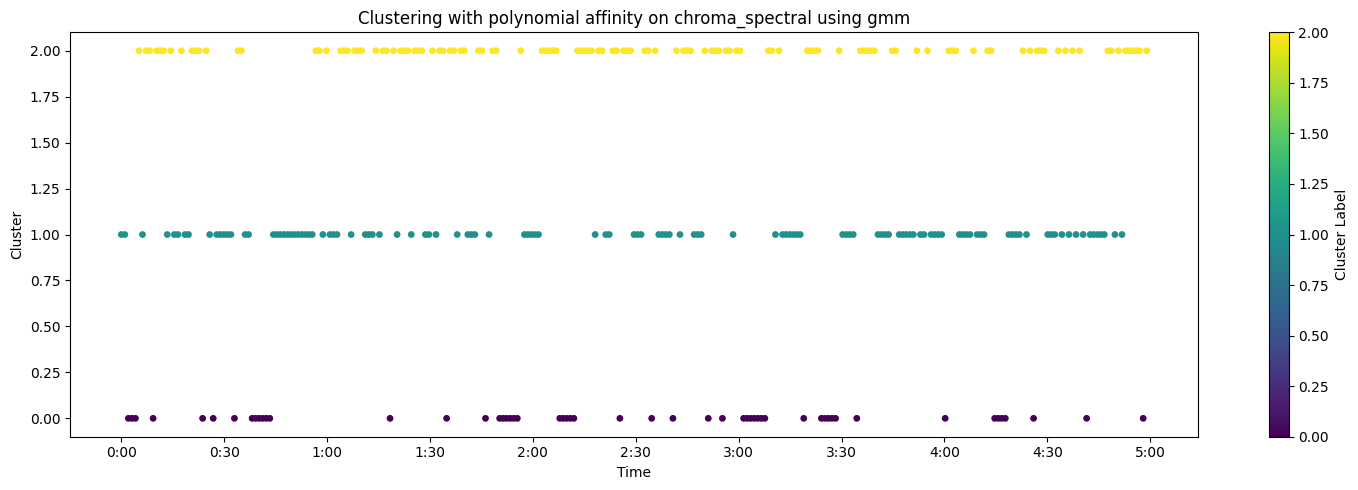

Timestamps for points in cluster 2:
5.15 seconds
7.22 seconds
8.25 seconds
10.31 seconds
11.34 seconds
12.37 seconds
14.43 seconds
17.53 seconds
20.62 seconds
21.65 seconds
22.68 seconds
24.74 seconds
34.02 seconds
35.05 seconds
56.70 seconds
57.73 seconds
59.79 seconds
63.92 seconds
64.95 seconds
65.98 seconds
68.04 seconds
69.07 seconds
70.10 seconds
74.23 seconds
76.29 seconds
77.32 seconds
79.38 seconds
81.44 seconds
82.47 seconds
83.51 seconds
85.57 seconds
86.60 seconds
87.63 seconds
90.72 seconds
92.78 seconds
93.81 seconds
95.88 seconds
96.91 seconds
98.97 seconds
100.00 seconds
104.12 seconds
105.15 seconds
108.25 seconds
109.28 seconds
116.49 seconds
122.68 seconds
123.71 seconds
124.74 seconds
125.77 seconds
126.80 seconds
132.99 seconds
134.02 seconds
135.05 seconds
136.08 seconds
137.11 seconds
139.18 seconds
140.21 seconds
143.30 seconds
144.33 seconds
146.39 seconds
147.42 seconds
148.45 seconds
152.58 seconds
153.61 seconds
155.67 seconds
161.86 seconds
163.92 seconds
1

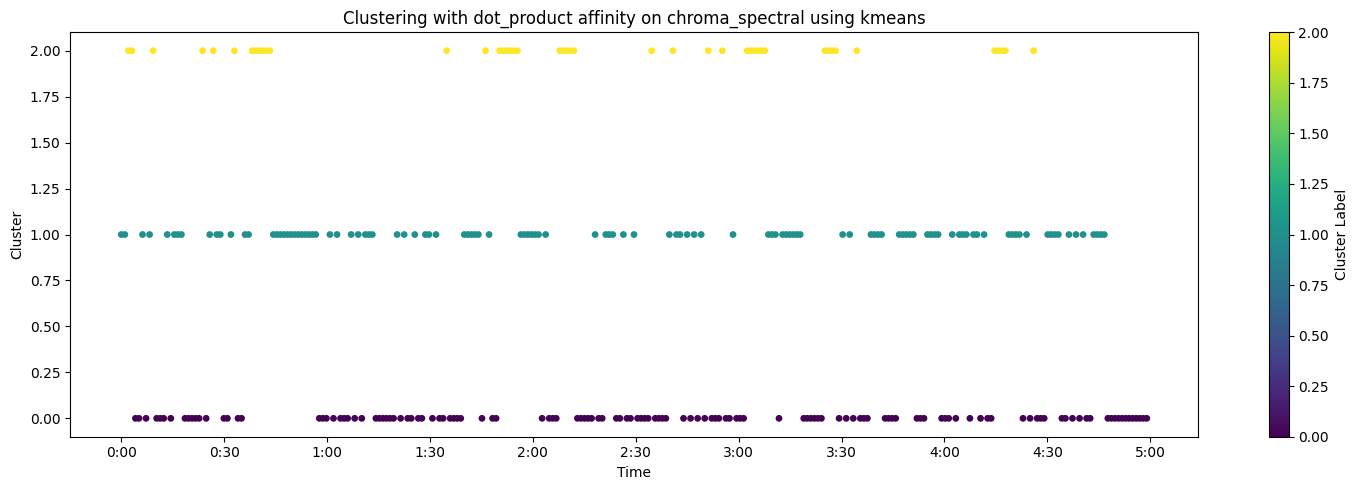

Timestamps for points in cluster 2:
2.06 seconds
3.09 seconds
9.28 seconds
23.71 seconds
26.80 seconds
32.99 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
43.30 seconds
94.85 seconds
106.19 seconds
110.31 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
127.84 seconds
128.87 seconds
129.90 seconds
130.93 seconds
131.96 seconds
154.64 seconds
160.82 seconds
171.13 seconds
175.26 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
205.15 seconds
206.19 seconds
207.22 seconds
208.25 seconds
214.43 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
265.98 seconds
45
Feature Set: chroma_spectral, Affinity: dot_product, Method: gmm, Silhouette: 0.10871510366011258


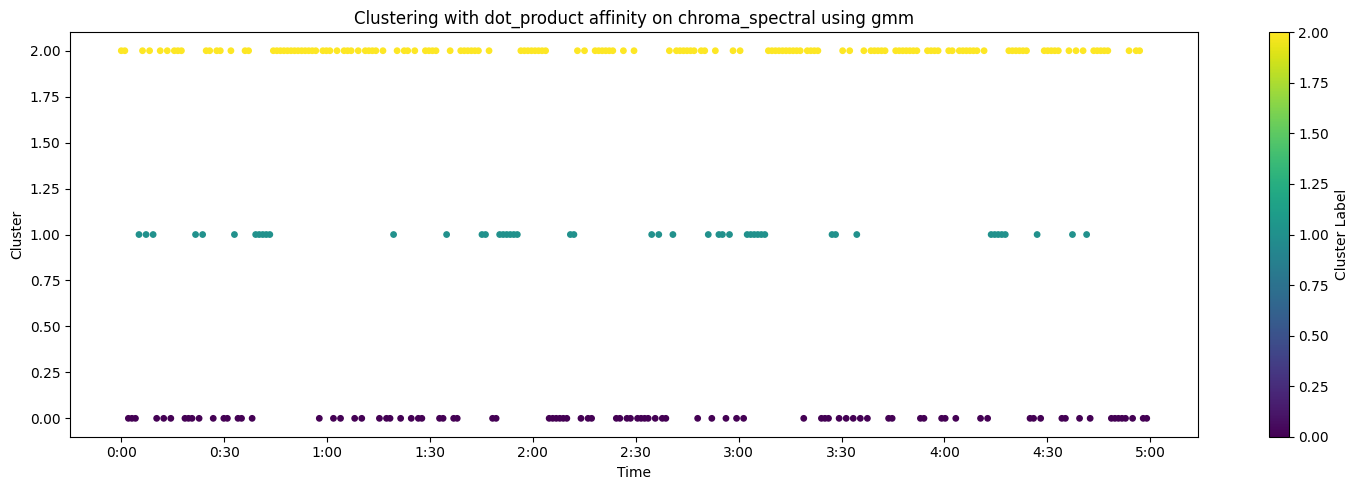

Timestamps for points in cluster 2:
0.00 seconds
1.03 seconds
6.19 seconds
8.25 seconds
11.34 seconds
13.40 seconds
15.46 seconds
16.49 seconds
17.53 seconds
24.74 seconds
25.77 seconds
27.84 seconds
28.87 seconds
31.96 seconds
36.08 seconds
37.11 seconds
44.33 seconds
45.36 seconds
46.39 seconds
47.42 seconds
48.45 seconds
49.48 seconds
50.52 seconds
51.55 seconds
52.58 seconds
53.61 seconds
54.64 seconds
55.67 seconds
56.70 seconds
58.76 seconds
59.79 seconds
60.82 seconds
62.89 seconds
64.95 seconds
65.98 seconds
67.01 seconds
69.07 seconds
71.13 seconds
72.16 seconds
73.20 seconds
74.23 seconds
76.29 seconds
80.41 seconds
82.47 seconds
83.51 seconds
85.57 seconds
88.66 seconds
89.69 seconds
90.72 seconds
91.75 seconds
95.88 seconds
98.97 seconds
100.00 seconds
101.03 seconds
102.06 seconds
103.09 seconds
104.12 seconds
107.22 seconds
116.49 seconds
117.53 seconds
118.56 seconds
119.59 seconds
120.62 seconds
121.65 seconds
122.68 seconds
123.71 seconds
132.99 seconds
135.05 seconds


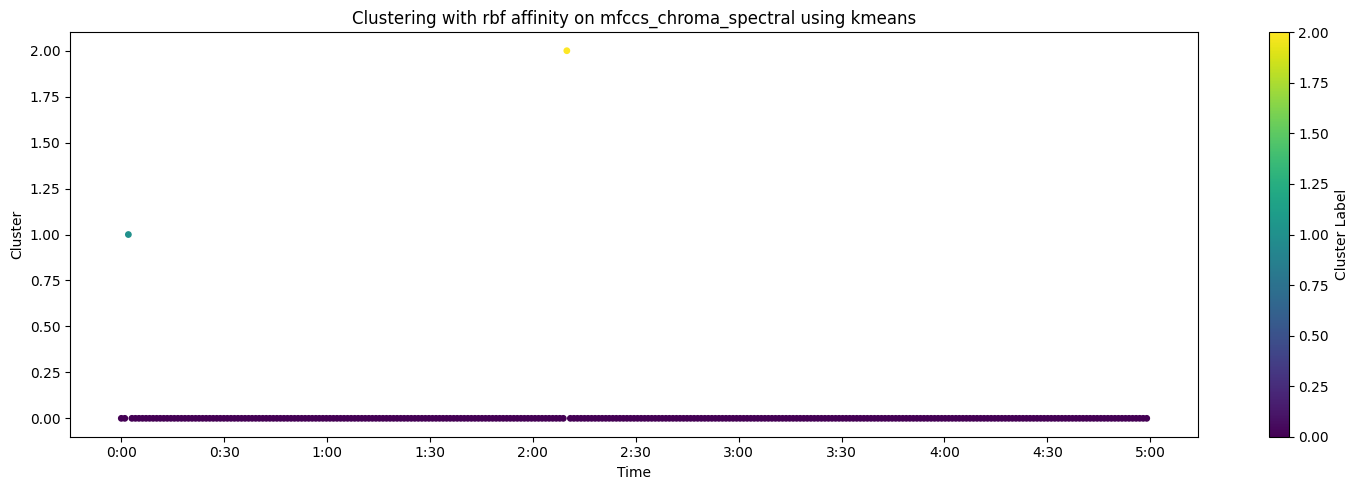

Timestamps for points in cluster 2:
129.90 seconds
1
Feature Set: mfccs_chroma_spectral, Affinity: rbf, Method: gmm, Silhouette: 0.7313816879133308


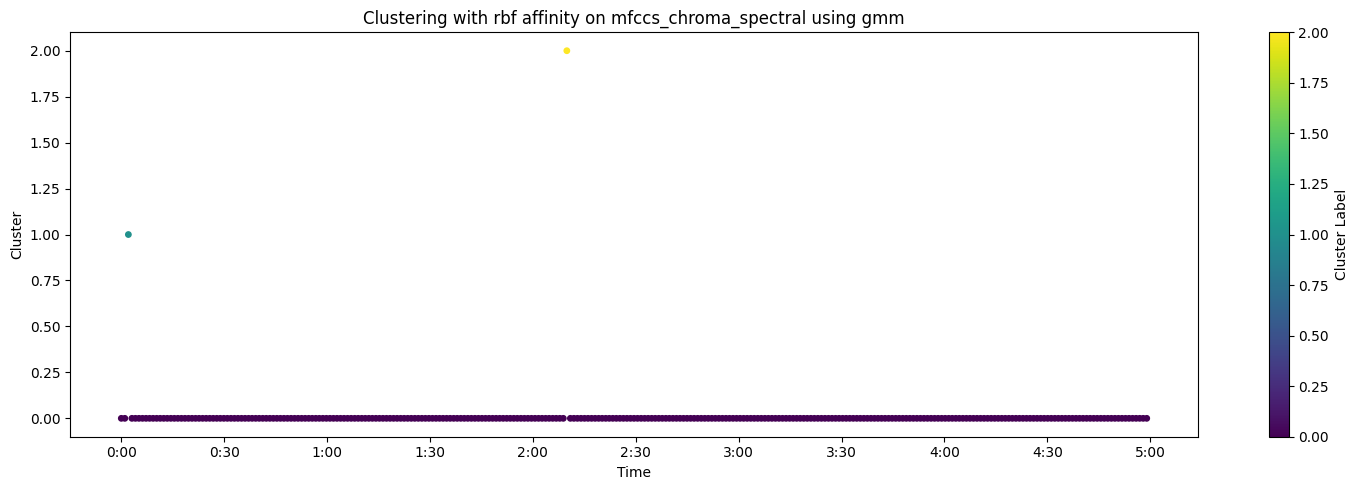

Timestamps for points in cluster 2:
129.90 seconds
1
Feature Set: mfccs_chroma_spectral, Affinity: cosine, Method: kmeans, Silhouette: 0.08489726505594268


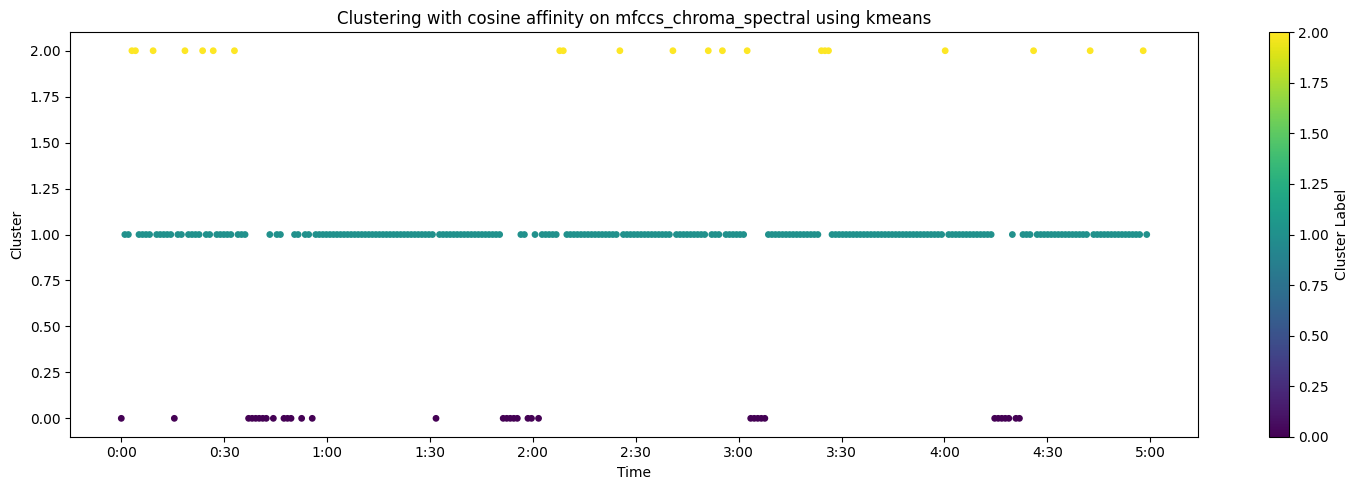

Timestamps for points in cluster 2:
3.09 seconds
4.12 seconds
9.28 seconds
18.56 seconds
23.71 seconds
26.80 seconds
32.99 seconds
127.84 seconds
128.87 seconds
145.36 seconds
160.82 seconds
171.13 seconds
175.26 seconds
182.47 seconds
204.12 seconds
205.15 seconds
206.19 seconds
240.21 seconds
265.98 seconds
282.47 seconds
297.94 seconds
21
Feature Set: mfccs_chroma_spectral, Affinity: cosine, Method: gmm, Silhouette: 0.2634394089197369


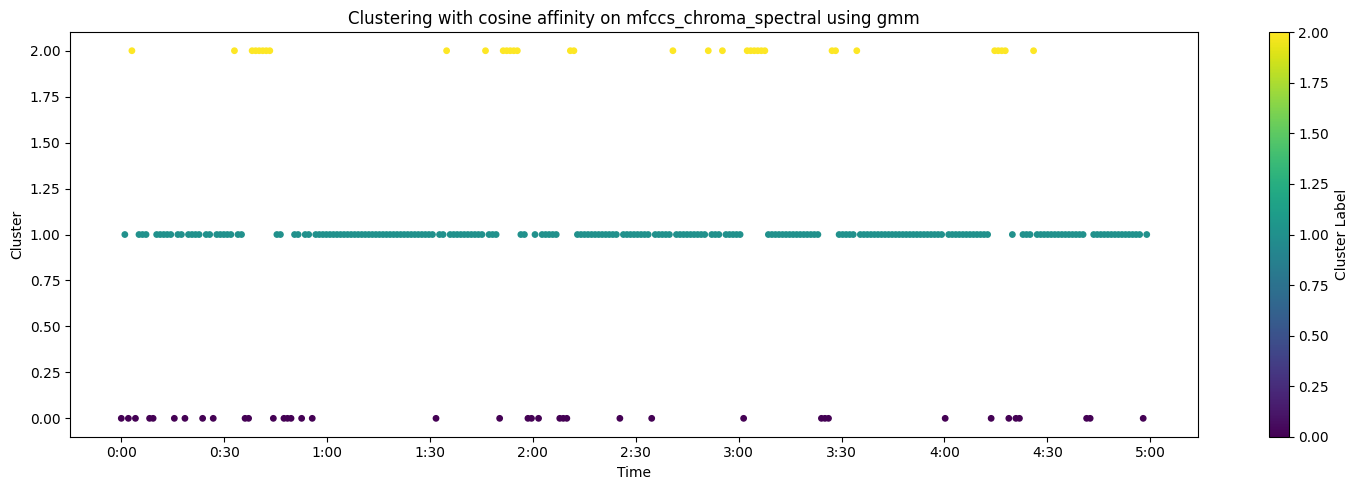

Timestamps for points in cluster 2:
3.09 seconds
32.99 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
43.30 seconds
94.85 seconds
106.19 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
130.93 seconds
131.96 seconds
160.82 seconds
171.13 seconds
175.26 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
207.22 seconds
208.25 seconds
214.43 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
265.98 seconds
34
Feature Set: mfccs_chroma_spectral, Affinity: polynomial, Method: kmeans, Silhouette: 0.7313816879133308


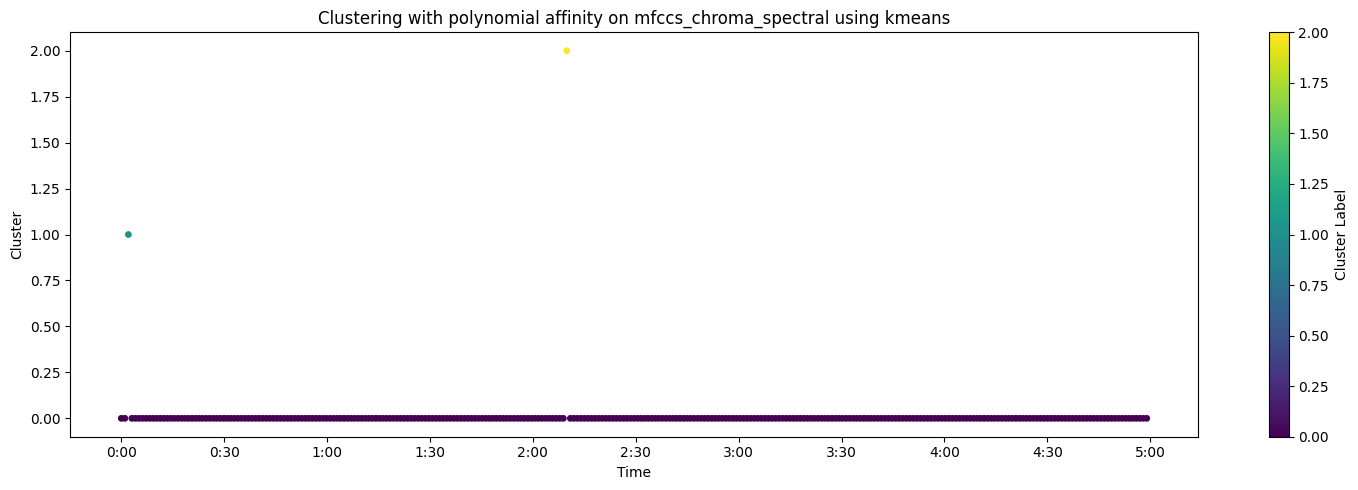

Timestamps for points in cluster 2:
129.90 seconds
1
Feature Set: mfccs_chroma_spectral, Affinity: polynomial, Method: gmm, Silhouette: 0.7313816879133308


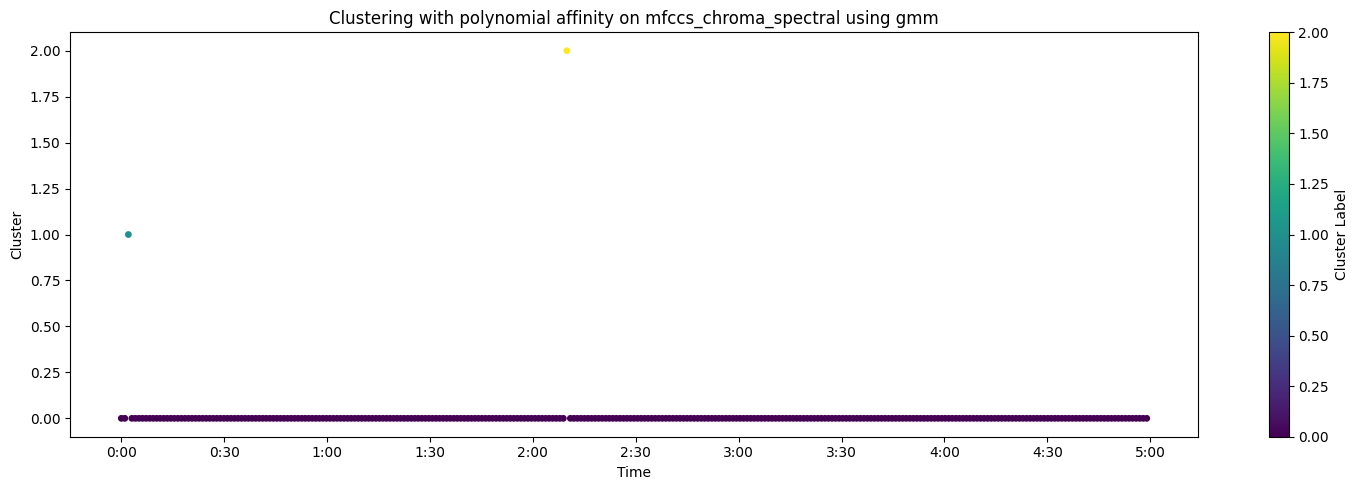

Timestamps for points in cluster 2:
129.90 seconds
1
Feature Set: mfccs_chroma_spectral, Affinity: dot_product, Method: kmeans, Silhouette: 0.4636690560016479


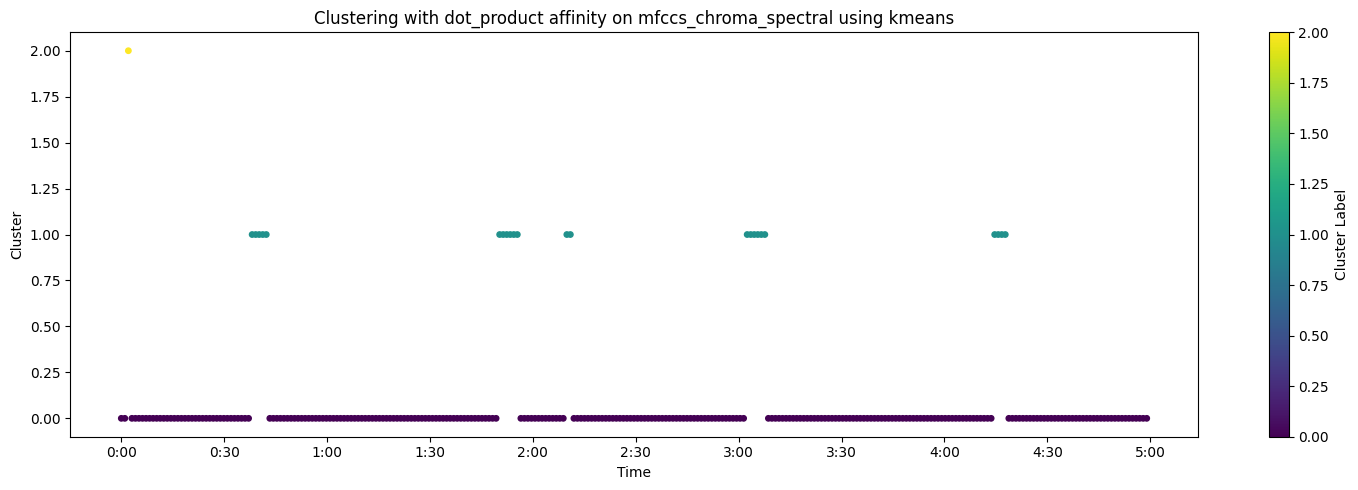

Timestamps for points in cluster 2:
2.06 seconds
1
Feature Set: mfccs_chroma_spectral, Affinity: dot_product, Method: gmm, Silhouette: 0.4002777437122788


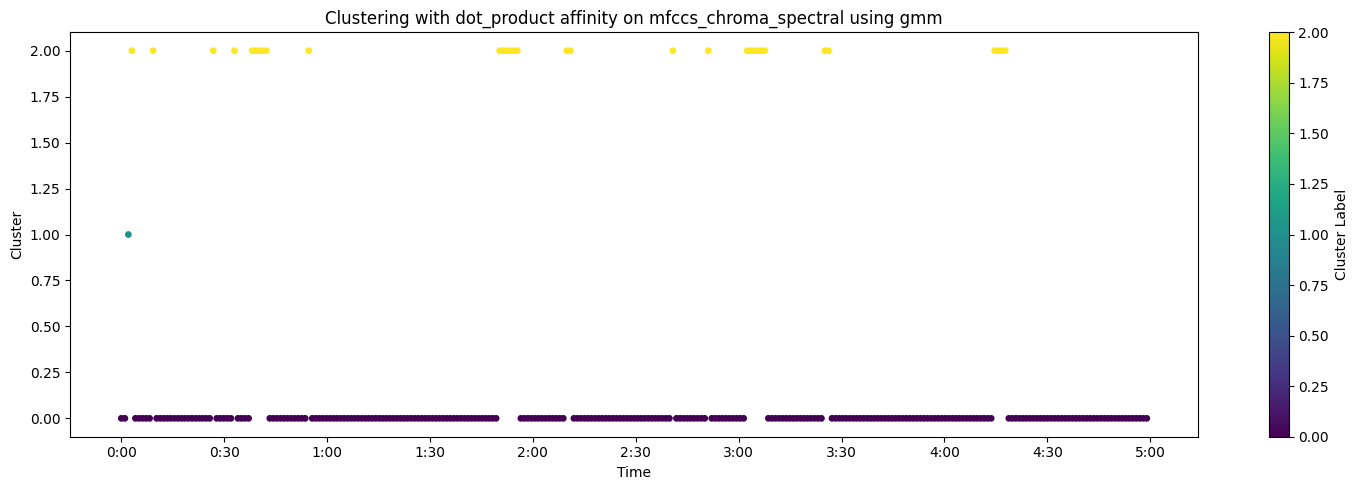

Timestamps for points in cluster 2:
3.09 seconds
9.28 seconds
26.80 seconds
32.99 seconds
38.14 seconds
39.18 seconds
40.21 seconds
41.24 seconds
42.27 seconds
54.64 seconds
110.31 seconds
111.34 seconds
112.37 seconds
113.40 seconds
114.43 seconds
115.46 seconds
129.90 seconds
130.93 seconds
160.82 seconds
171.13 seconds
182.47 seconds
183.51 seconds
184.54 seconds
185.57 seconds
186.60 seconds
187.63 seconds
205.15 seconds
206.19 seconds
254.64 seconds
255.67 seconds
256.70 seconds
257.73 seconds
32


In [8]:
affinity_matrices = {
    'rbf': rbf_kernel,
    'cosine':cosine_similarity,
    'polynomial': polynomial_kernel,
    'dot_product': lambda X: np.dot(X,X.T)
    }

clustering_methods = ['kmeans', 'gmm']

mfccs, mfccs_scaled, delta_scaled, chroma, chroma_scaled, spectral_scaled = extract_features(audio_data, sampling_rate)

# Extracted features
feature_sets = {
    'mfccs': mfccs,
    'mfccs_scaled': mfccs_scaled,
    'chroma': chroma,
    'chroma_scaled': chroma_scaled,
    'mfccs_delta': np.vstack([mfccs_scaled, delta_scaled]),
    'mfccs_chroma': np.vstack([mfccs_scaled, chroma_scaled]),
    'chroma_spectral': np.vstack([chroma_scaled, spectral_scaled]),
    'mfccs_chroma_spectral': np.vstack([mfccs_scaled, chroma_scaled, spectral_scaled])

}

for feature_name, features in feature_sets.items():
    for affinity_name, affinity_func in affinity_matrices.items():
        affinity_matrix = affinity_func(features.T)
        
        for method in clustering_methods:
            labels, silhouette = clustering(features.T, affinity_matrix, n_clusters=3, clustering_method=method)
            print(f'Feature Set: {feature_name}, Affinity: {affinity_name}, Method: {method}, Silhouette: {silhouette}')
            time_axis = np.arange(len(labels)) * (duration / len(labels))  # Adjust time axis
            plt.figure(figsize=(15, 5))
            plt.scatter(time_axis, labels, c=labels, cmap='viridis', s=15)
            plt.colorbar(label='Cluster Label')
            plt.title(f'Clustering with {affinity_name} affinity on {feature_name} using {method}')
            plt.xlabel('Time')
            plt.ylabel('Cluster')
            ax = plt.gca()
            ax.xaxis.set_major_formatter(FuncFormatter(time_ticks))
            plt.xticks(np.arange(0, duration+30, 30))
            plt.tight_layout()
            plt.show()
            
            cluster_number = 2 

            # Extract the indices for the points belonging to the specified cluster
            cluster_indices = np.where(labels == cluster_number)[0]

            # Extract the corresponding times for those indices
            cluster_times = time_axis[cluster_indices]
            count = 0
            # Print the timestamps of points in the specified cluster
            print(f"Timestamps for points in cluster {cluster_number}:")
            for time in cluster_times:
                print(f"{time:.2f} seconds")
                count = count +1
            print(count)

    
            

In [9]:
def plot_clusters(time_axis, labels, feature_name, method):
    plt.figure(figsize=(15, 5))
    plt.scatter(time_axis, labels, c=labels, cmap='viridis', s=5)
    plt.colorbar(label='Cluster Label')
    plt.title(f'{feature_name} - {method}')
    plt.xlabel('Time (s)')
    plt.ylabel('Cluster')
    plt.tight_layout()
    plt.show()


Feature Set: mfccs, K_Means Clustering


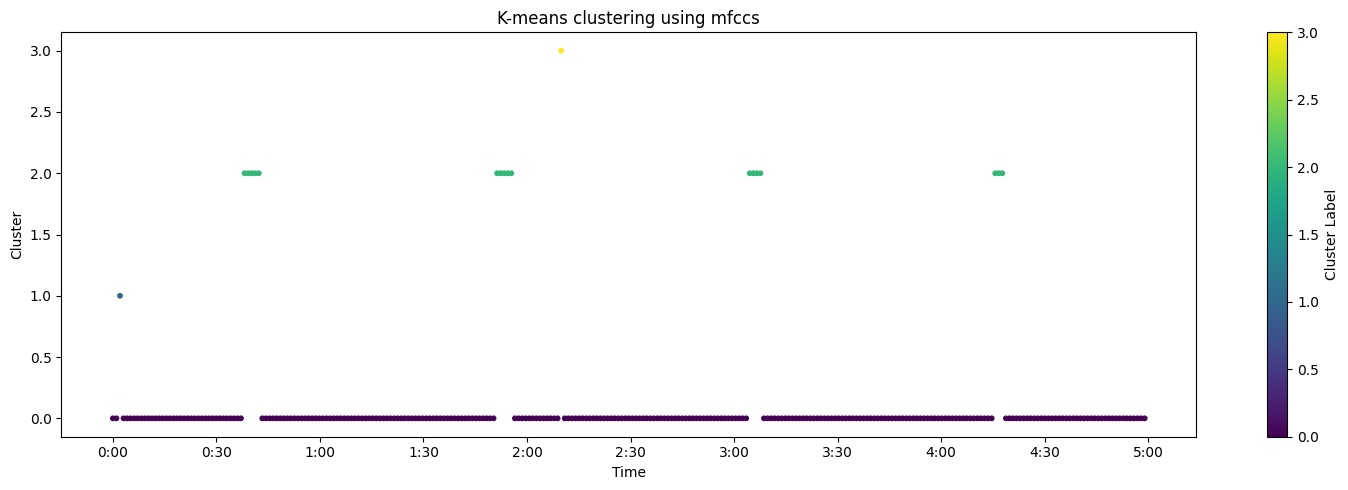

Silhouette Score:  0.7900468470438378
Feature Set: mfccs_scaled, K_Means Clustering


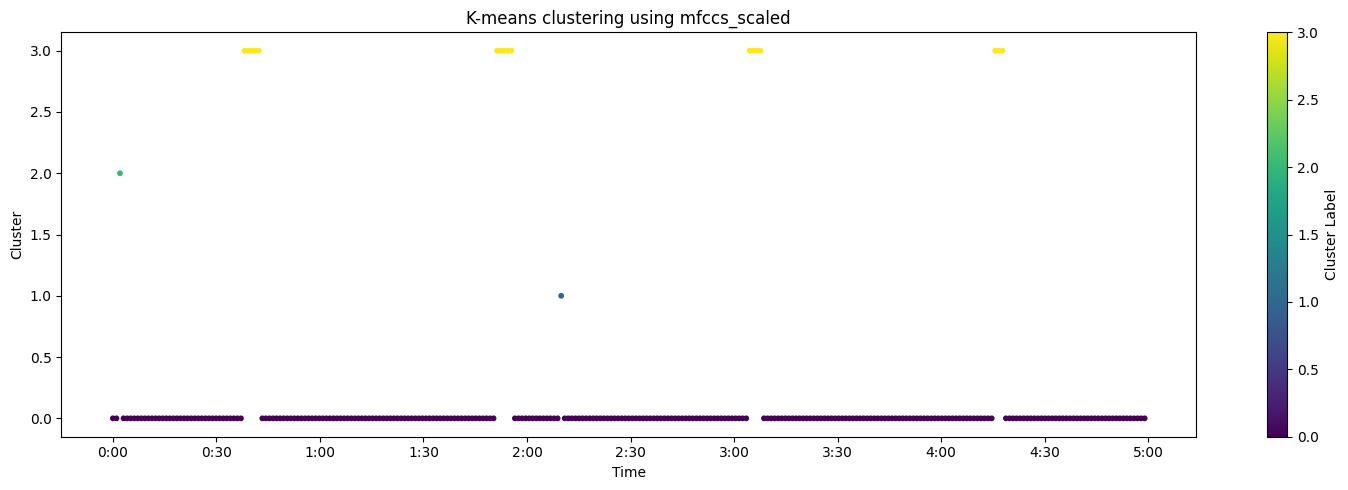

Silhouette Score:  0.7907995266495877
Feature Set: chroma, K_Means Clustering


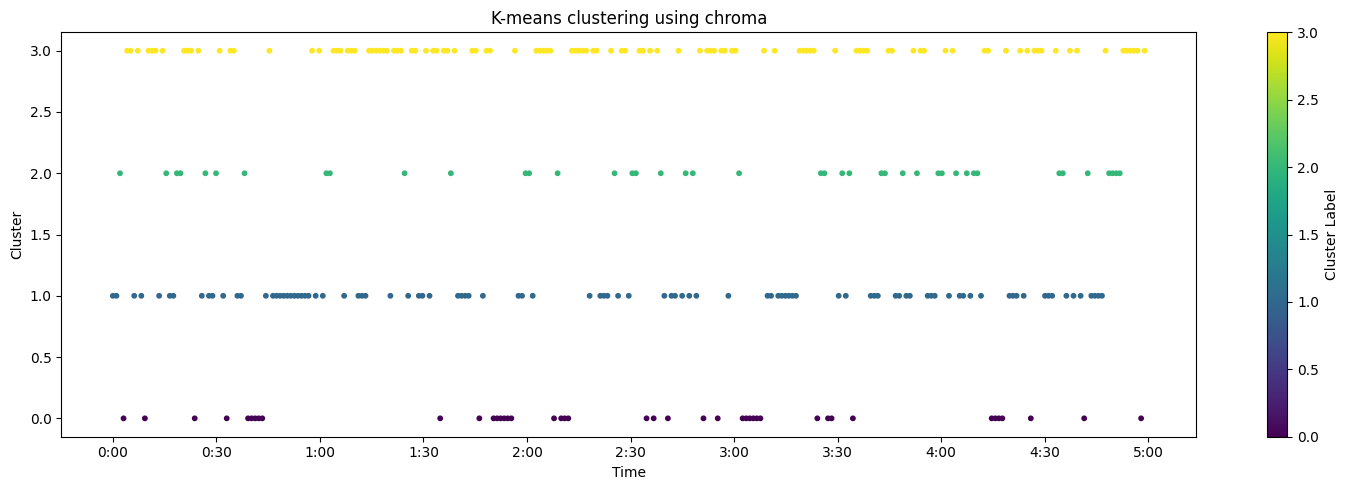

Silhouette Score:  0.18661083786140528
Feature Set: chroma_scaled, K_Means Clustering


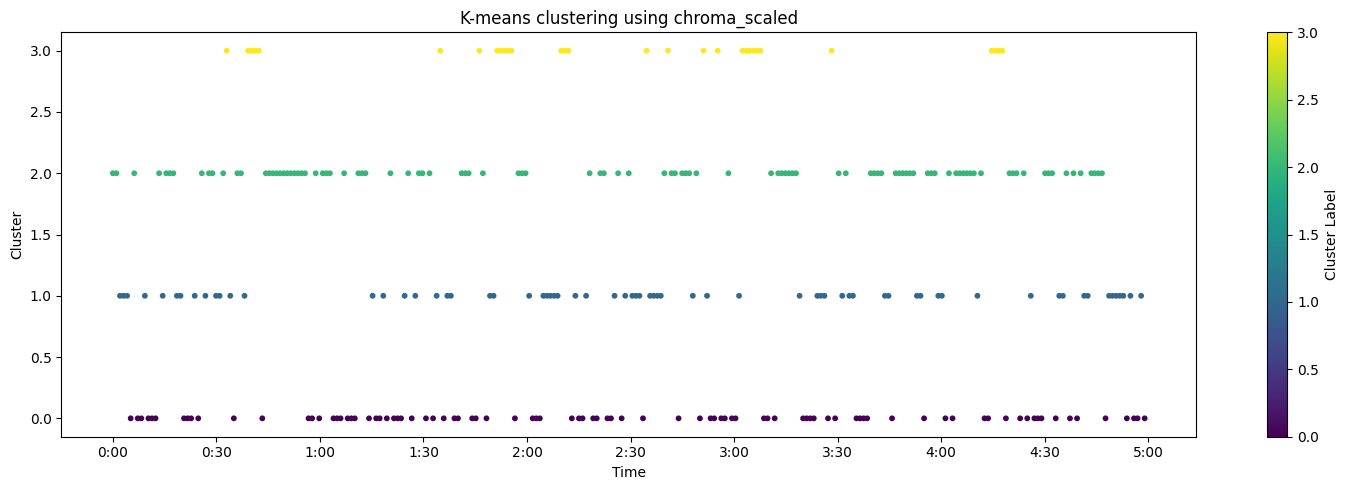

Silhouette Score:  0.18457998402342798
Feature Set: mfccs_delta, K_Means Clustering


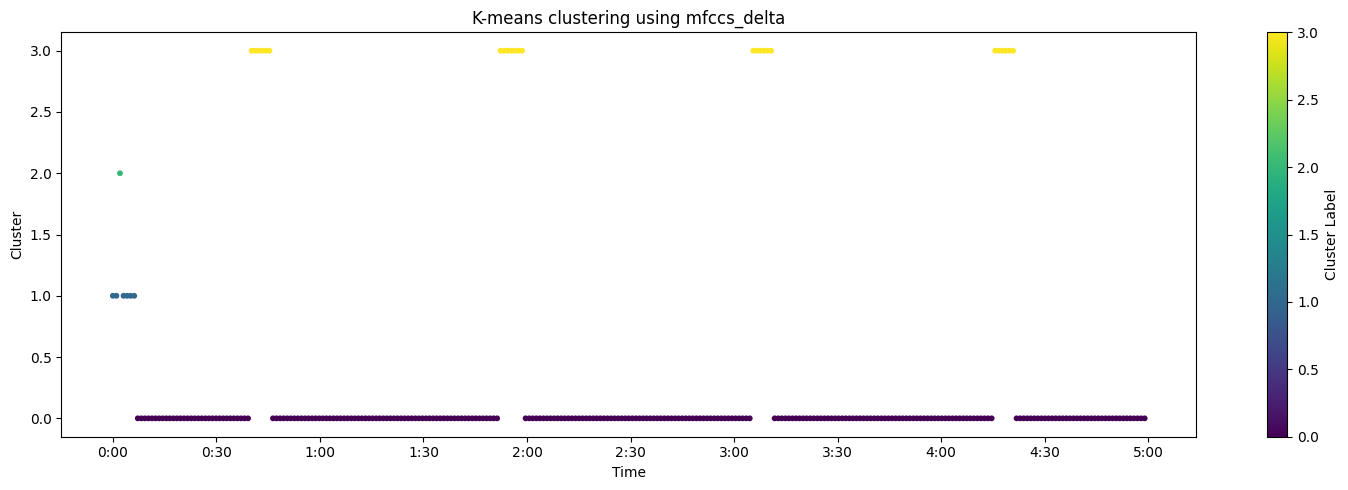

Silhouette Score:  0.6221430818311138
Feature Set: mfccs_chroma, K_Means Clustering


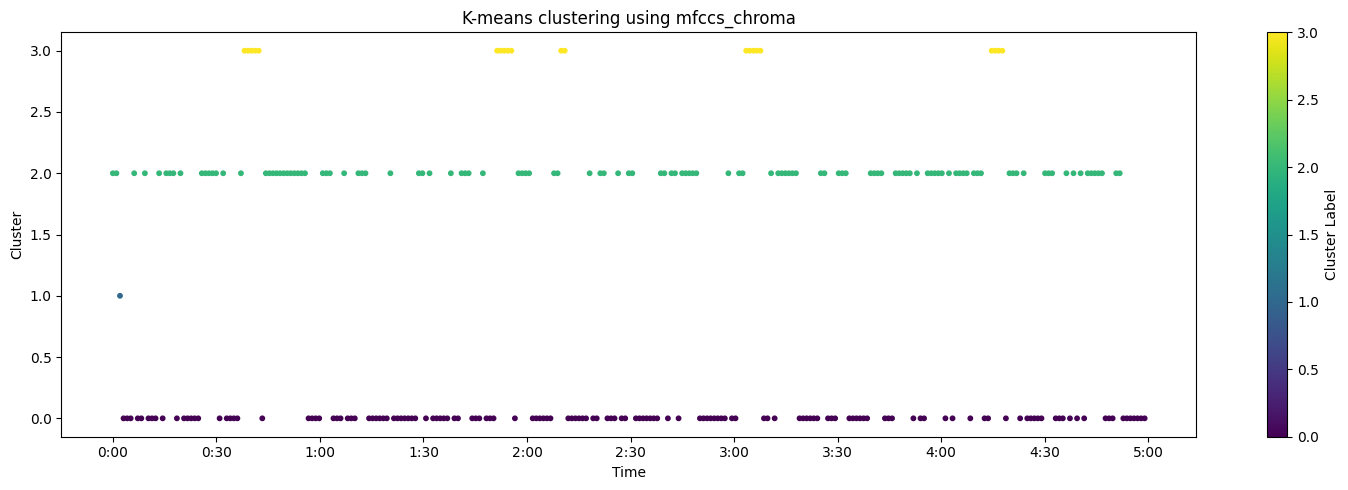

Silhouette Score:  0.15425331406465043
Feature Set: chroma_spectral, K_Means Clustering


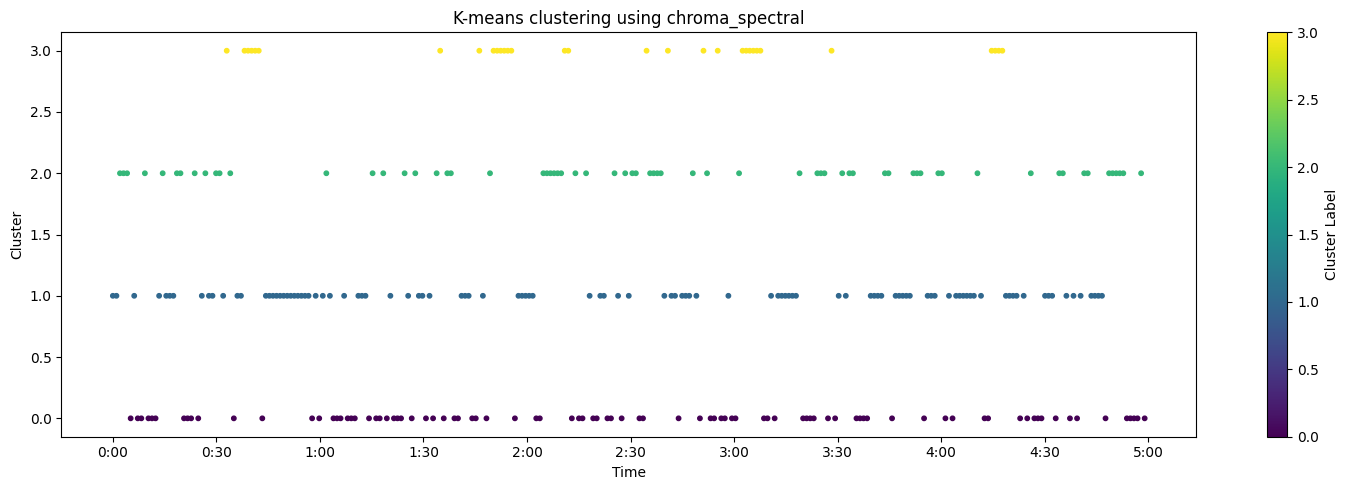

Silhouette Score:  0.1433673647434872
Feature Set: mfccs_chroma_spectral, K_Means Clustering


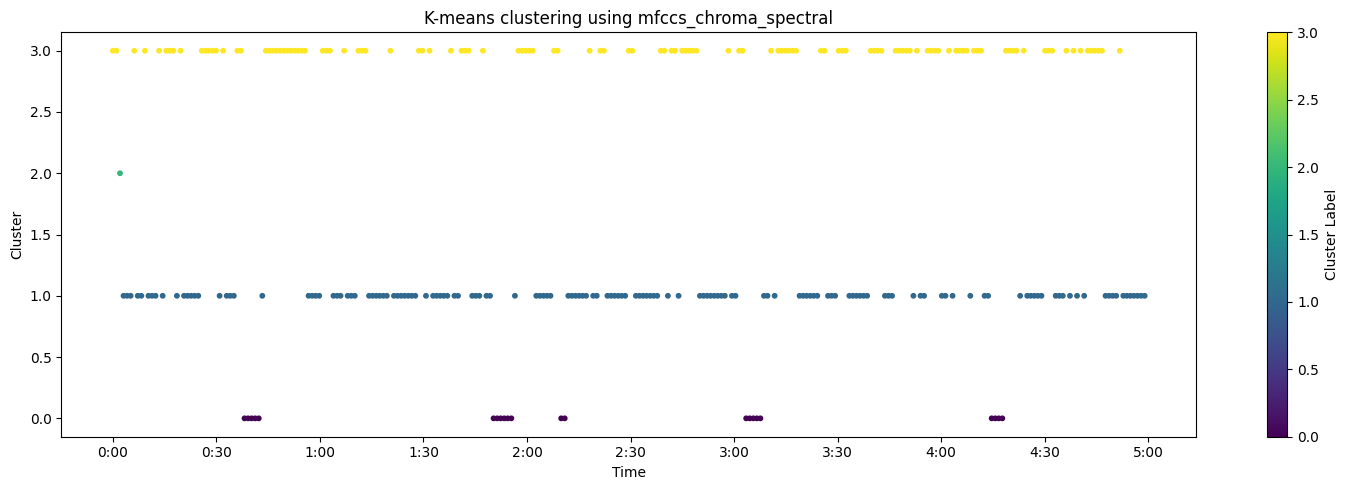

Silhouette Score:  0.12731929531686326


In [10]:
# K-means clustering algorithm
def traditional_clustering(X, n_clusters):
    model = KMeans(n_clusters=n_clusters, n_init=20)
    labels = model.fit_predict(X)
    if len(np.unique(labels)) > 1:
        silhouette = silhouette_score(X, labels)
    else:
        silhouette = None  

    return labels, silhouette

for feature_name, features in feature_sets.items():
    labels, silhouette = traditional_clustering(features.T, n_clusters=4)
    print(f'Feature Set: {feature_name}, K_Means Clustering')
    time_axis = np.arange(len(labels)) * (duration / len(labels)) 
    plt.figure(figsize=(15, 5))
    plt.scatter(time_axis, labels, c=labels, cmap='viridis', s=10)
    plt.colorbar(label='Cluster Label')
    plt.xlabel('Time')
    plt.ylabel('Cluster')
    plt.title(f'K-means clustering using {feature_name}')
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FuncFormatter(time_ticks))
    plt.xticks(np.arange(0, duration + 30, 30))
    plt.tight_layout()
    plt.show()
    print('Silhouette Score: ', silhouette)